In [2]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


In [3]:
import pandas as pd

def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
        
        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")
        
        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)
        
        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")
        
        return behavior_state_df
    
    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None

def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    
def play_video_with_ellipses_rotation(block, eye, path_to_video=False, xflip=False, transformation_matrix=None, phi_in_radians=False):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def play_video_with_ellipses_rotation_plus_major_axis(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['major_ax'])
            height = int(current_frame_data['minor_ax'])
            phi = np.deg2rad(float(current_frame_data['phi']))  # Convert angle to radians
            
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Calculate endpoints of major axis
            axis_length = max(width, height) / 2
            sin_phi = np.sin(phi)
            cos_phi = np.cos(phi)
            x1 = int(center_x + axis_length * cos_phi)
            y1 = int(center_y + axis_length * sin_phi)
            x2 = int(center_x - axis_length * cos_phi)
            y2 = int(center_y - axis_length * sin_phi)
            
            # Draw major axis
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {np.rad2deg(phi)}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def get_frame_count(video_path):
        """
        Get the number of frames for the video in the specified path using OpenCV.
    
        Parameters:
            video_path (str): Path to the video file.
    
        Returns:
            int: Number of frames in the video.
        """
        
        # Open the video file
        cap = cv2.VideoCapture(video_path)
    
        # Check if the video file is opened successfully
        if not cap.isOpened():
            print("Error: Could not open the video file.")
            return -1
    
        # Get the total number of frames in the video
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        # Release the VideoCapture object
        cap.release()
    
        return frame_count


# Block Instantiation

In [4]:

# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest

bad_blocks = [] # 
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
#animal = 'PV_62' || block_numbers = [23,24,25,26,27]
#animal = 'PV_126' # || block_numbers = [7,8,9,10,11,12,13,14] 
#animal = 'PV_24'  
animal = 'PV_126'
block_numbers = [13]
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=True)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 013 at Path: Z:\Nimrod\experiments\PV_126\2024_08_13\block_013, new OE version
Found the sample rate for block 013 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 013
got it!


In [5]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    #if 'pupil_diameter' not in block.left_eye_data.columns:
    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 013 has a parsed events file, reading...
Getting eye brightness values for block 013...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


# Over here there's an attempt at getting automatic LED annotations for movement quantification\

In [6]:

import cv2
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

def process_led_video_advanced(video_path, params=None, max_frames=None):
    """
    Process a video file containing 4 LED detections with improved candidate handling.
    
    Parameters:
      video_path (str): Path to the video file.
      params (dict, optional): Dictionary of detection parameters to override defaults.
         Expected keys:
           - brightness_thresh (default 200)
           - min_blob_area (default 5)
           - max_blob_area (default 500)
           - max_movement (default 50)
           - max_cluster_size (default 150)
           - expected_count (default 4)
      max_frames (int, optional): Process only the first X frames (useful for debugging).
    
    Returns:
      pd.DataFrame: DataFrame with columns:
        [frame, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem]
      where the LED order is:
        - For 4 detections: left-top, left-bottom, right-top, right-bottom.
        - For fewer detections, available positions are filled in order and the rest are NaN.
    """
    # Set default parameters and update with any provided values
    default_params = {
        'brightness_thresh': 200,
        'min_blob_area': 5,
        'max_blob_area': 500,
        'max_movement': 50,
        'max_cluster_size': 150,
        'expected_count': 4,
    }
    if params:
        default_params.update(params)
    
    brightness_thresh = default_params['brightness_thresh']
    min_blob_area = default_params['min_blob_area']
    max_blob_area = default_params['max_blob_area']
    max_movement = default_params['max_movement']
    max_cluster_size = default_params['max_cluster_size']
    expected_count = default_params['expected_count']
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return None

    # Read the first frame for ROI selection
    ret, first_frame = cap.read()
    if not ret:
        print("Error reading the first frame.")
        cap.release()
        return None

    # Let user select ROI (press ENTER or SPACE when done)
    roi = cv2.selectROI("Select ROI (press ENTER/SPACE when done)", first_frame, showCrosshair=True)
    cv2.destroyWindow("Select ROI (press ENTER/SPACE when done)")
    # ROI format: (x, y, w, h)
    
    # Rewind video to beginning and get total frame count
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames is not None:
        total_frames = min(total_frames, max_frames)
    
    results = []  # Will hold rows: [frame, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem]
    frame_number = 0
    prev_leds = None  # List of previous LED positions (length expected_count), with missing ones as None
    
    for _ in tqdm(range(total_frames), desc="Processing Frames", unit="frame"):
        ret, frame = cap.read()
        if not ret:
            break
        frame_number += 1

        # Convert to grayscale and threshold to get bright areas
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, brightness_thresh, 255, cv2.THRESH_BINARY)
        
        # Find contours in thresholded image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Build candidate list (dictionary with 'centroid' and 'area')
        candidates_full = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < min_blob_area or area > max_blob_area:
                continue
            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            candidates_full.append({"centroid": (cx, cy), "area": area})
        
        # Filter candidates inside ROI
        rx, ry, rw, rh = roi
        candidates_roi = [cand for cand in candidates_full if (rx <= cand["centroid"][0] <= rx+rw and ry <= cand["centroid"][1] <= ry+rh)]
        
        fallback_note = ""
        if len(candidates_roi) >= 2:
            candidates = candidates_roi
        else:
            candidates = candidates_full
            fallback_note = "ROI fallback; "
        
        # If still fewer than 2 candidates, we cannot reliably detect LEDs.
        if len(candidates) < 2:
            selected_leds = [np.nan] * expected_count
            notes = fallback_note + f"Not enough candidates: found {len(candidates)}"
            problem = True
        else:
            # --- Matching / Selection ---
            if prev_leds is None:
                # For first frame, choose candidates based on smallest area.
                sorted_cands = sorted(candidates, key=lambda d: d["area"])
                selected = [d["centroid"] for d in sorted_cands[:expected_count]]
            else:
                # Use previous detections to guide matching
                valid_prev = [pos for pos in prev_leds if pos is not None and not np.isnan(pos).any()]
                cand_positions = np.array([cand["centroid"] for cand in candidates])
                if len(valid_prev) > 0 and len(cand_positions) > 0:
                    prev_arr = np.array(valid_prev)
                    cost_matrix = np.linalg.norm(prev_arr[:, None, :] - cand_positions[None, :, :], axis=2)
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    matched = {}
                    used_cand = set()
                    for r, c in zip(row_ind, col_ind):
                        if cost_matrix[r, c] <= max_movement:
                            matched[tuple(valid_prev[r])] = tuple(cand_positions[c])
                            used_cand.add(c)
                    selected = []
                    for pos in prev_leds:
                        if pos is not None and (not np.isnan(pos).any()) and tuple(pos) in matched:
                            selected.append(matched[tuple(pos)])
                        else:
                            selected.append(None)
                    remaining_candidates = [tuple(cand_positions[i]) for i in range(len(cand_positions)) if i not in used_cand]
                    for i in range(len(selected)):
                        if selected[i] is None and remaining_candidates:
                            assigned = [p for p in selected if p is not None]
                            center = np.mean(np.array(assigned), axis=0) if assigned else np.array([frame.shape[1]//2, frame.shape[0]//2])
                            distances = [np.linalg.norm(np.array(c) - center) for c in remaining_candidates]
                            min_idx = np.argmin(distances)
                            if distances[min_idx] <= max_movement:
                                selected[i] = remaining_candidates[min_idx]
                                remaining_candidates.pop(min_idx)
                else:
                    sorted_cands = sorted(candidates, key=lambda d: d["area"])
                    selected = [d["centroid"] for d in sorted_cands[:expected_count]]
            
            if len(selected) < expected_count:
                selected.extend([None]*(expected_count - len(selected)))
            selected_leds = [tuple(s) if s is not None else np.nan for s in selected]
            
            # --- Ordering ---
            valid_positions = [s for s in selected_leds if not isinstance(s, float) and not (isinstance(s, np.ndarray) and np.isnan(s).all())]
            if len(valid_positions) == 4:
                sorted_by_x = sorted(selected_leds, key=lambda p: p[0] if not isinstance(p, float) else 1e6)
                left_cluster = sorted(sorted_by_x[:2], key=lambda p: p[1])
                right_cluster = sorted(sorted_by_x[2:], key=lambda p: p[1])
                selected_leds = left_cluster + right_cluster
            else:
                selected_leds = sorted(selected_leds, key=lambda p: p[0] if not isinstance(p, float) else 1e6)
            
            # --- Clustering Check ---
            valid_arr = np.array([p for p in selected_leds if not isinstance(p, float) and not (isinstance(p, np.ndarray) and np.isnan(p).all())])
            if valid_arr.size > 0:
                bbox_min = valid_arr.min(axis=0)
                bbox_max = valid_arr.max(axis=0)
                bbox_size = bbox_max - bbox_min
            else:
                bbox_size = np.array([0, 0])
            
            notes = fallback_note
            if len(valid_positions) < expected_count:
                notes += f"Only {len(valid_positions)} detections; "
                problem = True
            else:
                problem = False
            if bbox_size[0] > max_cluster_size or bbox_size[1] > max_cluster_size:
                notes += f"Cluster size too large: {bbox_size}; "
                problem = True

        # Unpack detections for output
        def unpack(idx):
            if len(selected_leds) > idx and isinstance(selected_leds[idx], tuple):
                return selected_leds[idx]
            return (np.nan, np.nan)
        
        (x1, y1) = unpack(0)
        (x2, y2) = unpack(1)
        (x3, y3) = unpack(2)
        (x4, y4) = unpack(3)
        
        results.append([frame_number, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem])
        
        # Update previous detections
        updated_prev = []
        for val in selected_leds:
            if isinstance(val, tuple):
                updated_prev.append(val)
            else:
                updated_prev.append(None)
        prev_leds = updated_prev

    cap.release()
    df = pd.DataFrame(results, columns=["frame", "x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "notes", "problem"])
    return df


def tune_detection_parameters(video_path):
    """
    Open an OpenCV GUI with sliders to tune detection parameters.
    The function displays the first frame of the video (with ROI selected)
    and overlays candidate detections based on the current slider settings.
    
    Returns:
      dict: A dictionary of parameter values to be passed to process_led_video_advanced().
            Keys: 'brightness_thresh', 'min_blob_area', 'max_blob_area',
                  'max_movement', 'max_cluster_size', 'expected_count'
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return None

    ret, frame = cap.read()
    if not ret:
        print("Error reading the first frame.")
        cap.release()
        return None

    # Let user select ROI
    roi = cv2.selectROI("Select ROI", frame, showCrosshair=True)
    cv2.destroyWindow("Select ROI")
    rx, ry, rw, rh = roi

    def nothing(x):
        pass

    cv2.namedWindow("Parameter Tuning", cv2.WINDOW_NORMAL)

    # Initial default values
    init_params = {
        "brightness_thresh": 230,
        "min_blob_area": 5,
        "max_blob_area": 70,
        "max_movement": 25,
        "max_cluster_size": 150,
        "expected_count": 4
    }

    # Create trackbars for each parameter
    cv2.createTrackbar("Brightness Thresh", "Parameter Tuning", init_params["brightness_thresh"], 255, nothing)
    cv2.createTrackbar("Min Blob Area", "Parameter Tuning", init_params["min_blob_area"], 1000, nothing)
    cv2.createTrackbar("Max Blob Area", "Parameter Tuning", init_params["max_blob_area"], 1000, nothing)
    cv2.createTrackbar("Max Movement", "Parameter Tuning", init_params["max_movement"], 100, nothing)
    cv2.createTrackbar("Max Cluster Size", "Parameter Tuning", init_params["max_cluster_size"], 300, nothing)
    cv2.createTrackbar("Expected Count", "Parameter Tuning", init_params["expected_count"], 10, nothing)

    while True:
        # Read current slider positions
        brightness_thresh = cv2.getTrackbarPos("Brightness Thresh", "Parameter Tuning")
        min_blob_area = cv2.getTrackbarPos("Min Blob Area", "Parameter Tuning")
        max_blob_area = cv2.getTrackbarPos("Max Blob Area", "Parameter Tuning")
        max_movement = cv2.getTrackbarPos("Max Movement", "Parameter Tuning")
        max_cluster_size = cv2.getTrackbarPos("Max Cluster Size", "Parameter Tuning")
        expected_count = cv2.getTrackbarPos("Expected Count", "Parameter Tuning")

        # Process the first frame using current parameters
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh_img = cv2.threshold(gray, brightness_thresh, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        candidates = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < min_blob_area or area > max_blob_area:
                continue
            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            if rx <= cx <= rx+rw and ry <= cy <= ry+rh:
                candidates.append((cx, cy))

        preview = frame.copy()
        cv2.rectangle(preview, (rx, ry), (rx+rw, ry+rh), (0, 255, 0), 2)
        for (cx, cy) in candidates:
            cv2.circle(preview, (cx, cy), 5, (0, 0, 255), -1)

        info_text = (f"Brightness: {brightness_thresh} | MinArea: {min_blob_area} | "
                     f"MaxArea: {max_blob_area} | MaxMove: {max_movement} | "
                     f"MaxCluster: {max_cluster_size} | Expected: {expected_count}")
        cv2.putText(preview, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255, 255, 255), 2)

        cv2.imshow("Parameter Tuning", preview)
        cv2.imshow("Threshold", thresh_img)

        key = cv2.waitKey(1) & 0xFF
        # Press 'q' to quit and output the parameter dictionary
        if key == ord('q'):
            break

    # Gather the final parameter values into a dictionary
    final_params = {
        "brightness_thresh": cv2.getTrackbarPos("Brightness Thresh", "Parameter Tuning"),
        "min_blob_area": cv2.getTrackbarPos("Min Blob Area", "Parameter Tuning"),
        "max_blob_area": cv2.getTrackbarPos("Max Blob Area", "Parameter Tuning"),
        "max_movement": cv2.getTrackbarPos("Max Movement", "Parameter Tuning"),
        "max_cluster_size": cv2.getTrackbarPos("Max Cluster Size", "Parameter Tuning"),
        "expected_count": cv2.getTrackbarPos("Expected Count", "Parameter Tuning")
    }

    cap.release()
    cv2.destroyAllWindows()
    return final_params

block.handle_arena_files()
params = tune_detection_parameters(str(block.arena_videos[-1]))



handling arena files
Arena video Names:
front_20240813T142952.mp4
left_20240813T142952.mp4
right_20240813T142952.mp4
top_20240813T142952.mp4


In [7]:
params

{'brightness_thresh': 238,
 'min_blob_area': 10,
 'max_blob_area': 70,
 'max_movement': 25,
 'max_cluster_size': 150,
 'expected_count': 4}

In [8]:
str(block.arena_videos[-1])

'Z:\\Nimrod\\experiments\\PV_126\\2024_08_13\\block_013\\arena_videos\\videos\\top_20240813T142952.mp4'

In [9]:
# second stage is analyzing the video
df_results = process_led_video_advanced(str(block.arena_videos[-1]))

Processing Frames: 100%|██████████| 13833/13833 [01:17<00:00, 178.18frame/s]


In [11]:
# third stage - perform filtering and process detections to produce head datapoints
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def smooth_segments(arr, sigma, max_gap=60):
    """
    Smooth an array with NaNs left intact except for short gaps.
    Gaps shorter than max_gap frames are linearly interpolated and then smoothed
    with a Gaussian filter on each contiguous (or bridged) segment.
    Longer gaps remain as NaN.
    """
    s = pd.Series(arr)
    s_interp = s.interpolate(method='linear', limit=max_gap-1, limit_direction='both')
    filled = s_interp.values
    out = np.copy(filled)
    n = len(arr)
    valid = ~np.isnan(filled)
    if not valid.any():
        return out

    segments = []
    seg_start = None
    for i in range(n):
        if valid[i]:
            if seg_start is None:
                seg_start = i
        else:
            if seg_start is not None:
                segments.append((seg_start, i))
                seg_start = None
    if seg_start is not None:
        segments.append((seg_start, n))
    
    for (start, end) in segments:
        out[start:end] = gaussian_filter1d(filled[start:end], sigma=sigma)
    
    original = s.values
    out[np.isnan(original)] = np.nan
    return out

def process_smoothed_path_data_from_df(df, sigma=5, jump_threshold=100):
    """
    Processes the LED detection data from the provided dataframe (df) without reading the video.
    Assumes df has:
      - 'frame' column (1-indexed frame numbers),
      - LED detection columns: 'x1', 'x2', 'x3', 'x4' and 'y1', 'y2', 'y3', 'y4',
      - 'notes' column with any initial detection comments.
    
    The function:
      1. Computes per-frame average (x,y) from the LED detections.
      2. Smooths these averages using smooth_segments (interpolating gaps < 60 frames).
      3. Iterates over every frame (using the dataframe rows in order) and:
           - Retrieves the smoothed (x,y) for that frame.
           - Compares it to the immediately preceding valid (non-NaN) smoothed point.
           - If the Euclidean distance exceeds jump_threshold, flags a "Large jump;" note.
           - If an error is flagged or the smoothed point is invalid, records NaN for that frame.
           - Otherwise, records the smoothed (x,y) along with combined notes.
      4. Returns a final analysis dataframe with columns:
           ["frame_number", "center_x", "center_y", "notes"]
    
    This function operates solely on the dataset, so it’s much faster and avoids random video file access.
    """
    # Ensure that the dataframe is sorted by frame number
    df = df.sort_values('frame').reset_index(drop=True)
    
    # Compute per-frame average (x,y) from LED detections.
    df['avg_x'] = df[['x1', 'x2', 'x3', 'x4']].mean(axis=1, skipna=True)
    df['avg_y'] = df[['y1', 'y2', 'y3', 'y4']].mean(axis=1, skipna=True)
    
    avg_x = df['avg_x'].values
    avg_y = df['avg_y'].values
    
    # Smooth coordinates (with interpolation for gaps < 60 frames)
    smoothed_x = smooth_segments(avg_x, sigma=sigma, max_gap=60)
    smoothed_y = smooth_segments(avg_y, sigma=sigma, max_gap=60)
    
    final_df_data = []  # To store rows: [frame_number, center_x, center_y, notes]
    prev_valid_point = None  # Immediately preceding valid smoothed point

    # Process each frame (row) sequentially.
    for idx in range(len(df)):
        frame_num = df.loc[idx, 'frame']
        current_x = smoothed_x[idx]
        current_y = smoothed_y[idx]
        valid_current = not (np.isnan(current_x) or np.isnan(current_y))
        
        # Retrieve original detection notes (if any)
        original_notes = df.loc[idx, 'notes'] if 'notes' in df.columns else ""
        
        additional_notes = ""
        jump_error = False
        
        if valid_current:
            new_point = (current_x, current_y)
            if prev_valid_point is not None:
                # Compute Euclidean distance from previous valid point
                distance = np.sqrt((current_x - prev_valid_point[0])**2 + (current_y - prev_valid_point[1])**2)
                if distance > jump_threshold:
                    jump_error = True
                    additional_notes += " Large jump;"
            prev_valid_point = new_point
        
        combined_notes = original_notes + additional_notes
        # Check for cluster error based on notes if needed:
        cluster_error = "Cluster size too large" in combined_notes
        
        error_flag = jump_error or cluster_error
        
        if (not valid_current) or error_flag:
            final_df_data.append([frame_num, np.nan, np.nan, combined_notes])
        else:
            final_df_data.append([frame_num, current_x, current_y, combined_notes])
    
    final_df = pd.DataFrame(final_df_data, columns=["frame_number", "center_x", "center_y", "notes"])
    return final_df

# Example usage:
# Assuming df_results is the output from process_led_video_advanced() with a proper 'frame' column.
final_analysis_df = process_smoothed_path_data_from_df(df_results, sigma=5, jump_threshold=60)
# print(final_analysis_df.head())


In [12]:
final_analysis_df.head()

,frame_number,center_x,center_y,notes
0,1,800.637456,256.143691,
1,2,800.641385,256.139128,
2,3,800.648839,256.130424,
3,4,800.659077,256.118358,
4,5,800.671143,256.103956,


In [13]:
# fourth stage - Visual inspection
import cv2
import numpy as np
import pandas as pd


def verify_final_analysis(video_path, final_analysis_df):
    """
    Opens an OpenCV window to verify final_analysis_df results by overlaying
    the processed LED detection data on the corresponding video frames.
    
    The function assumes final_analysis_df has the following columns:
       - frame_number (1-indexed)
       - center_x
       - center_y
       - notes (a string with any detection comments)
    
    It creates a trackbar (slider) so that you can jump to any frame.
    On each frame, it overlays:
       • A green circle at (center_x, center_y) if a valid detection exists,
         or displays a red "No valid detection" message if the center is NaN.
       • The frame number and the associated notes.
    
    Press 'q' to exit the viewer.
    
    Args:
        video_path (str): Path to the video file.
        final_analysis_df (pd.DataFrame): Dataframe with processed detection results.
    """
    # Get total frames from final_analysis_df (assuming the maximum frame_number equals total frames)
    total_frames = int(final_analysis_df['frame_number'].max())

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return

    window_name = "LED Verification Viewer"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 1280, 720)
    # Create a trackbar for frame navigation (1-indexed)
    cv2.createTrackbar("Frame", window_name, 1, total_frames, lambda x: None)

    while True:
        # Get current frame number from trackbar
        frame_num = cv2.getTrackbarPos("Frame", window_name)
        if frame_num < 1:
            frame_num = 1

        # Set video to the appropriate frame (0-indexed)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
        ret, frame = cap.read()
        if not ret:
            print(f"Frame read error at frame {frame_num}.")
            break

        overlay = frame.copy()

        # Retrieve the row for the current frame from final_analysis_df.
        # (Assumes one row per frame; if not, we take the first matching row.)
        row = final_analysis_df[final_analysis_df['frame_number'] == frame_num]
        if not row.empty:
            center_x = row.iloc[0]['center_x']
            center_y = row.iloc[0]['center_y']
            notes = row.iloc[0]['notes']
        else:
            center_x, center_y, notes = np.nan, np.nan, "No data for frame"

        # Overlay the LED detection: if valid, draw a green circle; if not, show a red warning.
        if not (np.isnan(center_x) or np.isnan(center_y)):
            cv2.circle(overlay, (int(center_x), int(center_y)), 5, (0, 255, 0), -1)
        else:
            cv2.putText(overlay, "No valid detection", (10, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Overlay the frame number and notes.
        cv2.putText(overlay, f"Frame: {frame_num}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        cv2.putText(overlay, f"Notes: {notes}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        cv2.imshow(window_name, overlay)

        key = cv2.waitKey(30) & 0xFF
        if key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# Example usage:

verify_final_analysis(str(block.arena_videos[-1]), final_analysis_df)


In [14]:
final_analysis_df.to_csv(r'Y:\Pogona_Vitticeps\PV126\1_Hunter\PV126_Trial116_eyeTracking_h9\block4\LED_based_model_position_analysis.csv')

In [11]:
# fifth stage = analyze displacement and add timestamps from final_sync_df
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def add_timestamps_from_arena_frame(final_analysis_df, final_sync_df, sample_rate):
    """
    Adds real timestamps (in ms) to the LED movement analysis dataframe (final_analysis_df)
    using the mapping from the final_sync_df's 'Arena_frame' column.
    
    final_sync_df is expected to have at least the columns:
       - 'Arena_TTL'
       - 'Arena_frame'
    and we compute:
       ms_axis = Arena_TTL * 1000 / sample_rate
    
    The function creates an interpolation function that maps Arena_frame numbers to ms_axis.
    Then, for each row in final_analysis_df (which should have a 'frame_number' column),
    the corresponding ms_axis timestamp is computed (with extrapolation enabled, so negative
    values can occur if the frame number is below the minimum Arena_frame).
    
    Args:
        final_analysis_df (pd.DataFrame): LED movement analysis dataframe with a 'frame_number' column.
        final_sync_df (pd.DataFrame): DataFrame with columns 'Arena_TTL' and 'Arena_frame'.
        sample_rate (float): The recording sample rate in Hz.
        
    Returns:
        pd.DataFrame: A copy of final_analysis_df with an additional 'ms_axis' column of timestamps.
    """
    # Make a copy of the sync dataframe
    sync_df = final_sync_df.copy()
    # Compute ms_axis in final_sync_df using: ms_axis = Arena_TTL * 1000 / sample_rate
    sync_df['ms_axis'] = sync_df['Arena_TTL'] * 1000 / sample_rate
    
    # Extract the Arena_frame numbers and corresponding ms timestamps
    arena_frames = sync_df['Arena_frame'].values
    ms_timestamps = sync_df['ms_axis'].values
    
    # Create an interpolation function mapping Arena_frame -> ms_axis
    # fill_value="extrapolate" allows values outside the given range (e.g. negative timestamps)
    interp_func = interp1d(arena_frames, ms_timestamps, fill_value="extrapolate")
    
    # Create a copy of final_analysis_df and compute the ms_axis for each row based on its frame_number
    final_df = final_analysis_df.copy()
    final_df['ms_axis'] = interp_func(final_df['frame_number'].values)
        # Compute displacements between consecutive frames (based on center coordinates)
    
    # For frame i (0-indexed) compared with previous frame i-1; first frame gets 0.
    displacements = [0]
    for i in tqdm(range(1, len(final_df))):
        x_prev, y_prev = final_df.loc[i-1, ['center_x', 'center_y']]
        x_curr, y_curr = final_df.loc[i, ['center_x', 'center_y']]
        if pd.notna(x_prev) and pd.notna(y_prev) and pd.notna(x_curr) and pd.notna(y_curr):
            dx = x_curr - x_prev
            dy = y_curr - y_prev
            displacements.append(np.sqrt(dx**2 + dy**2))
        else:
            displacements.append(0)
    final_df['displacement'] = displacements
    
    return final_df

# Example usage:
updated_df = add_timestamps_from_arena_frame(final_analysis_df, block.final_sync_df, block.sample_rate)
# Now updated_df has a new 'ms_axis' column with real timestamps in ms.


100%|██████████| 83485/83485 [00:54<00:00, 1525.09it/s]


In [12]:
#sixth stage - rolling window averaging
def rolling_window_analysis_led(df, window_size=2000, step_size=1000):
    """
    Bins LED movement data (from final_analysis_df with a real timestamp column 'ms_axis'
    and a 'displacement' column) into windows defined by window_size (in ms) and step_size (in ms).
    
    For each window, the function computes:
      - window_start: the start of the time window (ms)
      - window_end: the end of the time window (ms)
      - average_movAll: the average displacement (in pixels) over frames within that window
    
    Args:
        df (pd.DataFrame): LED analysis dataframe containing:
                           - 'ms_axis': real timestamp in ms for each frame.
                           - 'displacement': per-frame displacement (pixels).
        window_size (int): Size of each window in milliseconds (default 2000 ms).
        step_size (int): Step size in milliseconds between windows (default 1000 ms).
    
    Returns:
        pd.DataFrame: A dataframe with columns ['window_start', 'window_end', 'average_movAll'].
    """
    # Ensure the dataframe is sorted by ms_axis
    df = df.sort_values('ms_axis').reset_index(drop=True)
    
    t_min = df['ms_axis'].min()
    t_max = df['ms_axis'].max()
    # Create window start times (in ms)
    window_starts = np.arange(t_min, t_max + step_size, step_size)
    
    results = {'window_start': [], 'window_end': [], 'average_movAll': []}
    
    for start in window_starts:
        end = start + window_size
        window_data = df[(df['ms_axis'] >= start) & (df['ms_axis'] < end)]
        if not window_data.empty:
            avg_mov = window_data['displacement'].mean()
        else:
            avg_mov = 0
        results['window_start'].append(start)
        results['window_end'].append(end)
        results['average_movAll'].append(avg_mov)
    
    return pd.DataFrame(results)

movement_df = rolling_window_analysis_led(updated_df, window_size=2000, step_size=1000)

In [13]:
# choose threshold before the final stage: 
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Span, Slider, CustomJS
from bokeh.layouts import column

def tune_annotation_threshold(movement_df, initial_threshold=10):
    """
    Opens an interactive Bokeh plot in a Jupyter Notebook that displays
    the movement trace (using 'window_start' as x-axis and 'average_movAll' as y-axis)
    and a horizontal threshold line that can be adjusted via a slider.
    
    Args:
      movement_df (pd.DataFrame): DataFrame containing at least the columns
                                  'window_start' and 'average_movAll'.
      initial_threshold (float, optional): The starting threshold value.
    
    Returns:
      tuple: (slider, threshold_line) objects. The current slider value (accessible via
             slider.value) can be used as the threshold input to annotate_movement_df().
    """
    output_notebook()
    
    # Use 'window_start' if available; otherwise use the dataframe index.
    if "window_start" in movement_df.columns:
        x = movement_df["window_start"]
        x_label = "Window Start (ms)"
    else:
        x = movement_df.index
        x_label = "Index"
    y = movement_df["average_movAll"]
    
    source = ColumnDataSource(data=dict(x=x, y=y))
    
    # Create the plot with the movement trace.
    p = figure(title="Movement Trace with Adjustable Threshold", 
               x_axis_label=x_label, y_axis_label="Average Movement",
               plot_height=400, plot_width=700)
    p.line("x", "y", source=source, line_width=2, legend_label="average_movAll")
    p.circle("x", "y", source=source, size=5)
    
    # Create a horizontal line representing the threshold.
    threshold_line = Span(location=initial_threshold, dimension='width',
                          line_color='red', line_dash='dashed', line_width=2)
    p.add_layout(threshold_line)
    
    # Create a slider to adjust the threshold.
    slider = Slider(start=float(y.min()), end=float(y.max()), value=initial_threshold, 
                    step=0.1, title="Threshold Value")
    
    # Callback to update the horizontal line when the slider is moved.
    callback = CustomJS(args=dict(threshold_line=threshold_line), code="""
        threshold_line.location = cb_obj.value;
    """)
    slider.js_on_change("value", callback)
    
    layout = column(p, slider)
    show(layout)
    
    return slider, threshold_line

# Example usage in a Jupyter Notebook:
slider, threshold_line = tune_annotation_threshold(movement_df, initial_threshold=15)
# Once you are happy with the threshold value (slider.value), use it as:
# annotated_df = annotate_movement_df(movement_df, threshold=slider.value)


Loading BokehJS ...

In [14]:
# final stage - annotate behavior


def annotate_movement_df(movement_df, threshold):
    """
    Annotates the movement dataframe (which must include 'window_start',
    'window_end', 'average_movAll', and optionally 'notes') with a new 'behavior'
    column based on a chosen threshold.
    
    For each row:
      - If the 'notes' column (converted to lower-case) contains "large jump" or 
        "cluster size too large", assign behavior as "bad_annotation".
      - Otherwise, if average_movAll > threshold then assign "active", else "quiet".
    
    Args:
      movement_df (pd.DataFrame): DataFrame with columns ['window_start', 'window_end', 'average_movAll'].
                                  It may also include a 'notes' column.
      threshold (float): The chosen threshold (in pixels) for labeling a window as active.
    
    Returns:
      pd.DataFrame: A copy of movement_df with a new 'behavior' column.
    """
    df = movement_df.copy()

    def assign_behavior(row):
        notes = str(row.get("notes", "")).lower()  # Convert to string and lower-case
        if "large jump" in notes or "cluster size too large" in notes:
            return "bad_annotation"
        else:
            return "active" if row["average_movAll"] > threshold else "quiet"

    df["behavior"] = df.apply(assign_behavior, axis=1)
    return df


def collapse_behavior_df(movement_df):
    """
    Collapses consecutive windows in the movement dataframe that share the same 'behavior'
    into a single state segment.
    
    The input dataframe is expected to have columns:
      - 'window_start' (ms)
      - 'window_end' (ms)
      - 'behavior' (e.g., 'active', 'quiet', or 'bad_annotation')
    
    The function returns a compact behavioral dataframe with columns:
      - start_time (ms): beginning of the segment
      - end_time (ms): end of the segment
      - annotation: the behavior for that segment
    """
    if movement_df.empty:
        return pd.DataFrame(columns=["start_time", "end_time", "annotation"])

    segments = []
    current_behavior = movement_df.iloc[0]["behavior"]
    start_time = movement_df.iloc[0]["window_start"]
    end_time = movement_df.iloc[0]["window_end"]

    for i in range(1, len(movement_df)):
        row = movement_df.iloc[i]
        if row["behavior"] == current_behavior:
            # Extend the current segment.
            end_time = row["window_end"]
        else:
            segments.append({
                "start_time": start_time,
                "end_time": end_time,
                "annotation": current_behavior
            })
            current_behavior = row["behavior"]
            start_time = row["window_start"]
            end_time = row["window_end"]

    # Append the last segment.
    segments.append({
        "start_time": start_time,
        "end_time": end_time,
        "annotation": current_behavior
    })

    return pd.DataFrame(segments)


# Example usage:
# Suppose movement_df is your rolling-window analysis dataframe produced earlier (with real ms timestamps)
# For example:
# movement_df = rolling_window_analysis_led(updated_df, window_size=2000, step_size=1000)
#
# Now choose a threshold (based on your analysis, say 10 pixels):
# annotated_df = annotate_movement_df(movement_df, threshold=10.0)
# print(annotated_df.head())
#
# Then collapse consecutive windows with the same behavior:
# behavior_df = collapse_behavior_df(annotated_df)
# print(behavior_df.head())
annotated_df = annotate_movement_df(movement_df, threshold=1.00)

In [15]:
def create_behavior_df_from_movement(movement_df):
    """
    Collapses consecutive bins in the movement dataframe that share the same behavior into longer state windows.
    
    The input movement_df is expected to have columns:
       - window_start (ms)
       - window_end (ms)
       - behavior (e.g. 'active', 'quiet', or 'bad_annotation')
    
    The function returns a compact behavioral dataframe with columns:
       - start_time (ms)
       - end_time (ms)
       - annotation (the behavior for that segment)
    
    Consecutive bins with the same behavior are merged.
    """
    if movement_df.empty:
        return pd.DataFrame(columns=["start_time", "end_time", "annotation"])
    
    behavior_segments = []
    current_annotation = movement_df.iloc[0]['behavior']
    start_time = movement_df.iloc[0]['window_start']
    end_time = movement_df.iloc[0]['window_end']
    
    for i in range(1, len(movement_df)):
        row = movement_df.iloc[i]
        if row['behavior'] == current_annotation:
            # Extend the current segment.
            end_time = row['window_end']
        else:
            behavior_segments.append({
                'start_time': start_time,
                'end_time': end_time,
                'annotation': current_annotation
            })
            current_annotation = row['behavior']
            start_time = row['window_start']
            end_time = row['window_end']
    
    # Append the last segment.
    behavior_segments.append({
        'start_time': start_time,
        'end_time': end_time,
        'annotation': current_annotation
    })
    
    return pd.DataFrame(behavior_segments)

# Example usage:
# Assuming final_analysis_df (from your video processing) already has a 'ms_axis' column.
# movement_df = final_to_movement_df_with_behavior(final_analysis_df, bin_duration=1.0, threshold=10.0, bad_ratio=0.5)
# print(movement_df.head())
#
# Then, to collapse consecutive bins into state windows:
behavior_df = create_behavior_df_from_movement(annotated_df)
# print(behavior_df.head())

In [16]:
# Verify behavior_df: 
behavior_df

,start_time,end_time,annotation
0,53743.4,55743.4,active
1,54743.4,94743.4,quiet
2,93743.4,96743.4,active
3,95743.4,116743.4,quiet
4,115743.4,118743.4,active
...,...,...,...
147,1379743.4,1382743.4,quiet
148,1381743.4,1385743.4,active
149,1384743.4,1464743.4,quiet
150,1463743.4,1466743.4,active


In [17]:
#export as the accelerometer blocks: 
# Save to block and export to CSV
block.behavior_state = behavior_df
csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
behavior_df.to_csv(csv_path, index=False)
print(f"Behavior state saved to {csv_path}")

Behavior state saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\analysis\block_012_behavior_state.csv


In [ ]:
# From here, I think I can delete:

In [14]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm  # for the progress bar

def process_led_video(video_path):
    """
    Process a video file to extract LED positions with additional handling:
      - Opens a sample frame to interactively set the brightness threshold and max blob area.
      - For each frame, thresholds and detects blobs, then:
          * If 2 or more detections: selects the 2 smallest blobs (by area) as the LED positions.
            If more than 2 blobs, extra detections are summarized in the 'notes' column.
          * If fewer than 2 detections: records NaN for positions and notes the insufficiency.
      - A 'problem' column is set to True if the number of detections is not exactly 2.
      - A progress bar indicates the analysis progress.
      
    Returns:
      pd.DataFrame: DataFrame with columns [frame, x1, y1, x2, y2, notes, problem].
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return None

    # Read the first frame for interactive threshold parameter selection
    ret, sample_frame = cap.read()
    if not ret:
        print("Error reading the first frame.")
        cap.release()
        return None

    # Convert sample frame to grayscale
    sample_gray = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2GRAY)

    # Create a window for interactive thresholding
    cv2.namedWindow("Threshold Helper")

    # Create trackbars for brightness threshold and max blob area
    cv2.createTrackbar("Brightness Threshold", "Threshold Helper", 200, 255, lambda x: None)
    cv2.createTrackbar("Max Blob Area", "Threshold Helper", 50, 500, lambda x: None)

    print("Adjust the trackbars until only the LED blobs are visible.")
    print("Press 's' to save settings and continue, or 'q' to quit.")

    # Interactive loop to adjust thresholds
    while True:
        brightness_thresh = cv2.getTrackbarPos("Brightness Threshold", "Threshold Helper")
        max_blob_area = cv2.getTrackbarPos("Max Blob Area", "Threshold Helper")
        
        # Apply thresholding to the sample image
        _, thresh_img = cv2.threshold(sample_gray, brightness_thresh, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        display_frame = sample_frame.copy()
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area <= max_blob_area:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    cv2.circle(display_frame, (cx, cy), 5, (0, 255, 0), -1)
                    cv2.drawContours(display_frame, [cnt], -1, (0, 0, 255), 2)
        
        cv2.imshow("Threshold Helper", display_frame)
        key = cv2.waitKey(30) & 0xFF
        if key == ord('s'):
            break
        elif key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            return None

    cv2.destroyWindow("Threshold Helper")
    saved_brightness_thresh = brightness_thresh
    saved_max_blob_area = max_blob_area
    print(f"Saved thresholds: Brightness={saved_brightness_thresh}, Max Blob Area={saved_max_blob_area}")
    
    # Reset video to start processing from the beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    # Get total frame count for progress tracking
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Prepare a list to hold the results: [frame, x1, y1, x2, y2, notes, problem]
    results = []
    frame_number = 0

    pbar = tqdm(total=total_frames, desc="Processing Frames", unit="frame")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_number += 1
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh_img = cv2.threshold(gray, saved_brightness_thresh, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Gather detections as dictionaries with centroid and area
        detections = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area <= saved_max_blob_area:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    detections.append({"centroid": (cx, cy), "area": area})
        
        # Initialize default output for the frame
        x1 = y1 = x2 = y2 = np.nan
        notes = ""
        problem = False
        
        if len(detections) >= 2:
            # Sort by area so that the two smallest blobs are selected
            detections_sorted = sorted(detections, key=lambda d: d['area'])
            chosen = detections_sorted[:2]
            # For consistency, sort the chosen blobs by x-coordinate
            chosen = sorted(chosen, key=lambda d: d['centroid'][0])
            x1, y1 = chosen[0]['centroid']
            x2, y2 = chosen[1]['centroid']
            
            if len(detections) > 2:
                # Prepare a note about the extra detections
                extra = detections_sorted[2:]
                extra_info = "; ".join([f"({d['centroid'][0]},{d['centroid'][1]}, area={d['area']:.1f})" for d in extra])
                notes = f"Extra detections: {extra_info}"
                problem = True
            else:
                problem = False
        else:
            # Fewer than 2 detections found
            notes = f"Insufficient detections: found {len(detections)} blob(s)."
            problem = True
        
        results.append([frame_number, x1, y1, x2, y2, notes, problem])
        pbar.update(1)
    pbar.close()
    cap.release()
    
    # Create and return a DataFrame with the results
    df = pd.DataFrame(results, columns=["frame", "x1", "y1", "x2", "y2", "notes", "problem"])
    return df

# Example usage:
df_results = process_led_video(str(block.arena_videos[-1]))
# print(df_results.head())


Adjust the trackbars until only the LED blobs are visible.
Press 's' to save settings and continue, or 'q' to quit.


In [15]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment  # for matching detections frame-to-frame

def process_led_video_advanced(video_path, max_frames=None):
    """
    Process a video file containing 4 LED detections with improved candidate handling.
    
    This function:
      1. Displays the first frame for ROI selection.
      2. For each frame, thresholds the image and finds candidate blobs.
         - It first considers only candidates within the ROI. If fewer than 2 are found,
           it falls back to using all candidates from the full frame.
      3. If at least 2 candidates are available, it attempts to match the current candidates
         to the previous frame's detections (if available) to enforce temporal continuity.
      4. It then fills up to 4 LED positions (expected maximum). If fewer than 4 candidates are
         available, missing positions are set to NaN.
      5. The output ordering is as follows:
           - If 4 candidates: sorted into two clusters (left/right) then top-bottom.
           - If fewer than 4: candidates are sorted by x coordinate.
      6. A note is recorded if a fallback from ROI was used or if fewer than 4 candidates were found,
         and a "problem" flag is set in those cases.
      7. An optional parameter `max_frames` lets you process only the first X frames (useful for debugging).
    
    Returns:
      pd.DataFrame: DataFrame with columns:
        [frame, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem]
      where the LED order is:
        - For 4 detections: left-top, left-bottom, right-top, right-bottom.
        - For fewer detections, available positions are filled in order and the rest are NaN.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return None

    # Read the first frame for ROI selection
    ret, first_frame = cap.read()
    if not ret:
        print("Error reading the first frame.")
        cap.release()
        return None

    # Let user select ROI (press ENTER or SPACE when done)
    roi = cv2.selectROI("Select ROI (press ENTER/SPACE when done)", first_frame, showCrosshair=True)
    cv2.destroyWindow("Select ROI (press ENTER/SPACE when done)")
    # ROI format: (x, y, w, h)
    
    # --- PARAMETERS (adjust as needed) ---
    brightness_thresh = 200      # threshold to isolate bright spots
    min_blob_area = 5            # ignore blobs smaller than this
    max_blob_area = 500          # ignore blobs larger than this (likely reflections)
    max_movement = 50            # maximum allowed movement (pixels) between frames
    max_cluster_size = 150       # maximum allowed spatial spread for the LED group
    expected_count = 4           # maximum number of LED detections to report
    # -------------------------------------------

    # Rewind video to beginning and get total frame count
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames is not None:
        total_frames = min(total_frames, max_frames)
    
    results = []  # Will hold rows: [frame, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem]
    frame_number = 0
    prev_leds = None  # List of previous LED positions (length expected_count), with missing ones as None
    
    for _ in tqdm(range(total_frames), desc="Processing Frames", unit="frame"):
        ret, frame = cap.read()
        if not ret:
            break
        frame_number += 1

        # Convert to grayscale and threshold to get bright areas
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, brightness_thresh, 255, cv2.THRESH_BINARY)
        
        # Find contours in thresholded image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Build candidate list (dictionary with 'centroid' and 'area')
        candidates_full = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < min_blob_area or area > max_blob_area:
                continue
            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            candidates_full.append({"centroid": (cx, cy), "area": area})
        
        # Filter candidates inside ROI
        rx, ry, rw, rh = roi
        candidates_roi = [cand for cand in candidates_full if (rx <= cand["centroid"][0] <= rx+rw and ry <= cand["centroid"][1] <= ry+rh)]
        
        fallback_note = ""
        if len(candidates_roi) >= 2:
            candidates = candidates_roi
        else:
            candidates = candidates_full
            fallback_note = "ROI fallback; "
        
        # If still fewer than 2 candidates, we cannot reliably detect LEDs.
        if len(candidates) < 2:
            selected_leds = [np.nan] * expected_count
            notes = fallback_note + f"Not enough candidates: found {len(candidates)}"
            problem = True
        else:
            # --- Matching / Selection ---
            # If first frame (no previous detections), choose candidates based on smallest area.
            if prev_leds is None:
                # Sort by area (lowest first) and take up to expected_count.
                sorted_cands = sorted(candidates, key=lambda d: d["area"])
                selected = [d["centroid"] for d in sorted_cands[:expected_count]]
            else:
                # Use previous detections (only consider those that are not NaN)
                valid_prev = [pos for pos in prev_leds if pos is not None and not np.isnan(pos).any()]
                # Create list of candidate positions
                cand_positions = np.array([cand["centroid"] for cand in candidates])
                # If we have valid previous detections, build cost matrix and use Hungarian matching.
                if len(valid_prev) > 0 and len(cand_positions) > 0:
                    prev_arr = np.array(valid_prev)
                    cost_matrix = np.linalg.norm(prev_arr[:, None, :] - cand_positions[None, :, :], axis=2)
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    # Create a dictionary mapping from previous detection (as tuple) to candidate position
                    matched = {}
                    used_cand = set()
                    for r, c in zip(row_ind, col_ind):
                        if cost_matrix[r, c] <= max_movement:
                            matched[tuple(valid_prev[r])] = tuple(cand_positions[c])
                            used_cand.add(c)
                    # For each previous detection (in order of the full expected 4), if it was valid, assign its matched candidate.
                    selected = []
                    for pos in prev_leds:
                        if pos is not None and (not np.isnan(pos).any()) and tuple(pos) in matched:
                            selected.append(matched[tuple(pos)])
                        else:
                            selected.append(None)
                    # For any slot that remains None, try to assign an unassigned candidate.
                    remaining_candidates = [tuple(cand_positions[i]) for i in range(len(cand_positions)) if i not in used_cand]
                    for i in range(len(selected)):
                        if selected[i] is None and remaining_candidates:
                            # Pick the candidate closest to the cluster center of already assigned detections
                            assigned = [p for p in selected if p is not None]
                            if assigned:
                                center = np.mean(np.array(assigned), axis=0)
                            else:
                                center = np.array([frame.shape[1]//2, frame.shape[0]//2])
                            distances = [np.linalg.norm(np.array(c) - center) for c in remaining_candidates]
                            min_idx = np.argmin(distances)
                            if distances[min_idx] <= max_movement:
                                selected[i] = remaining_candidates[min_idx]
                                remaining_candidates.pop(min_idx)
                else:
                    # No valid previous detections to guide matching: fallback to sorting by area.
                    sorted_cands = sorted(candidates, key=lambda d: d["area"])
                    selected = [d["centroid"] for d in sorted_cands[:expected_count]]
            
            # Pad the selection to always have length equal to expected_count.
            if len(selected) < expected_count:
                selected.extend([None]*(expected_count - len(selected)))
            # Replace any None with np.nan arrays.
            selected_leds = [tuple(s) if s is not None else np.nan for s in selected]
            
            # --- Ordering ---
            # If we have exactly 4 detections, split into left/right clusters.
            # Otherwise, simply sort by x coordinate.
            valid_positions = [s for s in selected_leds if not isinstance(s, float) and not (isinstance(s, np.ndarray) and np.isnan(s).all())]
            if len(valid_positions) == 4:
                # Sort by x coordinate
                sorted_by_x = sorted(selected_leds, key=lambda p: p[0] if not isinstance(p, float) else 1e6)
                left_cluster = sorted(sorted_by_x[:2], key=lambda p: p[1])
                right_cluster = sorted(sorted_by_x[2:], key=lambda p: p[1])
                selected_leds = left_cluster + right_cluster
            else:
                # Sort whatever detections we have by x coordinate.
                selected_leds = sorted(selected_leds, key=lambda p: p[0] if not isinstance(p, float) else 1e6)
            
            # --- Clustering Check ---
            # If we have at least one valid detection, check if the spatial spread is reasonable.
            valid_arr = np.array([p for p in selected_leds if not isinstance(p, float) and not (isinstance(p, np.ndarray) and np.isnan(p).all())])
            if valid_arr.size > 0:
                bbox_min = valid_arr.min(axis=0)
                bbox_max = valid_arr.max(axis=0)
                bbox_size = bbox_max - bbox_min
            else:
                bbox_size = np.array([0, 0])
            
            # Record notes and problem flag if not all 4 detected
            notes = fallback_note
            if len([p for p in selected_leds if not isinstance(p, float) and not (isinstance(p, np.ndarray) and np.isnan(p).all())]) < expected_count:
                notes += f"Only {len(valid_positions)} detections; "
                problem = True
            else:
                problem = False
            if bbox_size[0] > max_cluster_size or bbox_size[1] > max_cluster_size:
                notes += f"Cluster size too large: {bbox_size}; "
                problem = True

        # Unpack detections for output; if a detection is missing, record as np.nan.
        if isinstance(selected_leds[0], tuple):
            x1, y1 = selected_leds[0]
        else:
            x1 = y1 = np.nan
        if len(selected_leds) > 1 and isinstance(selected_leds[1], tuple):
            x2, y2 = selected_leds[1]
        else:
            x2 = y2 = np.nan
        if len(selected_leds) > 2 and isinstance(selected_leds[2], tuple):
            x3, y3 = selected_leds[2]
        else:
            x3 = y3 = np.nan
        if len(selected_leds) > 3 and isinstance(selected_leds[3], tuple):
            x4, y4 = selected_leds[3]
        else:
            x4 = y4 = np.nan
        
        results.append([frame_number, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem])
        
        # Update previous detections: keep a list of length expected_count (with None for missing)
        updated_prev = []
        for val in selected_leds:
            if isinstance(val, tuple):
                updated_prev.append(val)
            else:
                updated_prev.append(None)
        prev_leds = updated_prev

    cap.release()
    df = pd.DataFrame(results, columns=["frame", "x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "notes", "problem"])
    return df

# Example usage:
# Process only the first 100 frames for debugging:
# df_results = process_led_video_advanced('your_video.mp4', max_frames=100)
# print(df_results.head())

# Example usage:
df_results = process_led_video_advanced(str(block.arena_videos[-1]))
# print(df_results.head())


Processing Frames: 100%|██████████| 13833/13833 [01:20<00:00, 172.17frame/s]


In [16]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def smooth_segments(arr, sigma, max_gap=60):
    """
    Smooth an array with NaNs left intact except for short gaps.
    Gaps shorter than max_gap frames are linearly interpolated and then smoothed
    with a Gaussian filter on each contiguous (or bridged) segment.
    Longer gaps remain as NaN.
    """
    s = pd.Series(arr)
    s_interp = s.interpolate(method='linear', limit=max_gap-1, limit_direction='both')
    filled = s_interp.values
    out = np.copy(filled)
    n = len(arr)
    valid = ~np.isnan(filled)
    if not valid.any():
        return out

    segments = []
    seg_start = None
    for i in range(n):
        if valid[i]:
            if seg_start is None:
                seg_start = i
        else:
            if seg_start is not None:
                segments.append((seg_start, i))
                seg_start = None
    if seg_start is not None:
        segments.append((seg_start, n))
    
    for (start, end) in segments:
        out[start:end] = gaussian_filter1d(filled[start:end], sigma=sigma)
    
    original = s.values
    out[np.isnan(original)] = np.nan
    return out

def process_smoothed_path_data_from_df(df, sigma=5, jump_threshold=100):
    """
    Processes the LED detection data from the provided dataframe (df) without reading the video.
    Assumes df has:
      - 'frame' column (1-indexed frame numbers),
      - LED detection columns: 'x1', 'x2', 'x3', 'x4' and 'y1', 'y2', 'y3', 'y4',
      - 'notes' column with any initial detection comments.
    
    The function:
      1. Computes per-frame average (x,y) from the LED detections.
      2. Smooths these averages using smooth_segments (interpolating gaps < 60 frames).
      3. Iterates over every frame (using the dataframe rows in order) and:
           - Retrieves the smoothed (x,y) for that frame.
           - Compares it to the immediately preceding valid (non-NaN) smoothed point.
           - If the Euclidean distance exceeds jump_threshold, flags a "Large jump;" note.
           - If an error is flagged or the smoothed point is invalid, records NaN for that frame.
           - Otherwise, records the smoothed (x,y) along with combined notes.
      4. Returns a final analysis dataframe with columns:
           ["frame_number", "center_x", "center_y", "notes"]
    
    This function operates solely on the dataset, so it’s much faster and avoids random video file access.
    """
    # Ensure that the dataframe is sorted by frame number
    df = df.sort_values('frame').reset_index(drop=True)
    
    # Compute per-frame average (x,y) from LED detections.
    df['avg_x'] = df[['x1', 'x2', 'x3', 'x4']].mean(axis=1, skipna=True)
    df['avg_y'] = df[['y1', 'y2', 'y3', 'y4']].mean(axis=1, skipna=True)
    
    avg_x = df['avg_x'].values
    avg_y = df['avg_y'].values
    
    # Smooth coordinates (with interpolation for gaps < 60 frames)
    smoothed_x = smooth_segments(avg_x, sigma=sigma, max_gap=60)
    smoothed_y = smooth_segments(avg_y, sigma=sigma, max_gap=60)
    
    final_df_data = []  # To store rows: [frame_number, center_x, center_y, notes]
    prev_valid_point = None  # Immediately preceding valid smoothed point

    # Process each frame (row) sequentially.
    for idx in range(len(df)):
        frame_num = df.loc[idx, 'frame']
        current_x = smoothed_x[idx]
        current_y = smoothed_y[idx]
        valid_current = not (np.isnan(current_x) or np.isnan(current_y))
        
        # Retrieve original detection notes (if any)
        original_notes = df.loc[idx, 'notes'] if 'notes' in df.columns else ""
        
        additional_notes = ""
        jump_error = False
        
        if valid_current:
            new_point = (current_x, current_y)
            if prev_valid_point is not None:
                # Compute Euclidean distance from previous valid point
                distance = np.sqrt((current_x - prev_valid_point[0])**2 + (current_y - prev_valid_point[1])**2)
                if distance > jump_threshold:
                    jump_error = True
                    additional_notes += " Large jump;"
            prev_valid_point = new_point
        
        combined_notes = original_notes + additional_notes
        # Check for cluster error based on notes if needed:
        cluster_error = "Cluster size too large" in combined_notes
        
        error_flag = jump_error or cluster_error
        
        if (not valid_current) or error_flag:
            final_df_data.append([frame_num, np.nan, np.nan, combined_notes])
        else:
            final_df_data.append([frame_num, current_x, current_y, combined_notes])
    
    final_df = pd.DataFrame(final_df_data, columns=["frame_number", "center_x", "center_y", "notes"])
    return final_df

# Example usage:
# Assuming df_results is the output from process_led_video_advanced() with a proper 'frame' column.
final_analysis_df = process_smoothed_path_data_from_df(df_results, sigma=5, jump_threshold=100)
# print(final_analysis_df.head())


In [18]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def add_timestamps_from_arena_frame(final_analysis_df, final_sync_df, sample_rate):
    """
    Adds real timestamps (in ms) to the LED movement analysis dataframe (final_analysis_df)
    using the mapping from the final_sync_df's 'Arena_frame' column.
    
    final_sync_df is expected to have at least the columns:
       - 'Arena_TTL'
       - 'Arena_frame'
    and we compute:
       ms_axis = Arena_TTL * 1000 / sample_rate
    
    The function creates an interpolation function that maps Arena_frame numbers to ms_axis.
    Then, for each row in final_analysis_df (which should have a 'frame_number' column),
    the corresponding ms_axis timestamp is computed (with extrapolation enabled, so negative
    values can occur if the frame number is below the minimum Arena_frame).
    
    Args:
        final_analysis_df (pd.DataFrame): LED movement analysis dataframe with a 'frame_number' column.
        final_sync_df (pd.DataFrame): DataFrame with columns 'Arena_TTL' and 'Arena_frame'.
        sample_rate (float): The recording sample rate in Hz.
        
    Returns:
        pd.DataFrame: A copy of final_analysis_df with an additional 'ms_axis' column of timestamps.
    """
    # Make a copy of the sync dataframe
    sync_df = final_sync_df.copy()
    # Compute ms_axis in final_sync_df using: ms_axis = Arena_TTL * 1000 / sample_rate
    sync_df['ms_axis'] = sync_df['Arena_TTL'] * 1000 / sample_rate
    
    # Extract the Arena_frame numbers and corresponding ms timestamps
    arena_frames = sync_df['Arena_frame'].values
    ms_timestamps = sync_df['ms_axis'].values
    
    # Create an interpolation function mapping Arena_frame -> ms_axis
    # fill_value="extrapolate" allows values outside the given range (e.g. negative timestamps)
    interp_func = interp1d(arena_frames, ms_timestamps, fill_value="extrapolate")
    
    # Create a copy of final_analysis_df and compute the ms_axis for each row based on its frame_number
    final_df = final_analysis_df.copy()
    final_df['ms_axis'] = interp_func(final_df['frame_number'].values)
        # Compute displacements between consecutive frames (based on center coordinates)
    
    # For frame i (0-indexed) compared with previous frame i-1; first frame gets 0.
    displacements = [0]
    for i in tqdm(range(1, len(final_df))):
        x_prev, y_prev = final_df.loc[i-1, ['center_x', 'center_y']]
        x_curr, y_curr = final_df.loc[i, ['center_x', 'center_y']]
        if pd.notna(x_prev) and pd.notna(y_prev) and pd.notna(x_curr) and pd.notna(y_curr):
            dx = x_curr - x_prev
            dy = y_curr - y_prev
            displacements.append(np.sqrt(dx**2 + dy**2))
        else:
            displacements.append(0)
    final_df['displacement'] = displacements
    
    return final_df

# Example usage:
updated_df = add_timestamps_from_arena_frame(final_analysis_df, block.final_sync_df, block.sample_rate)
# Now updated_df has a new 'ms_axis' column with real timestamps in ms.


100%|██████████| 13832/13832 [00:09<00:00, 1479.20it/s]


In [33]:
import cv2
import numpy as np
import pandas as pd

def verify_final_analysis(video_path, final_analysis_df):
    """
    Opens an OpenCV window to verify final_analysis_df results by overlaying
    the processed LED detection data on the corresponding video frames.
    
    The function assumes final_analysis_df has the following columns:
       - frame_number (1-indexed)
       - center_x
       - center_y
       - notes (a string with any detection comments)
    
    It creates a trackbar (slider) so that you can jump to any frame.
    On each frame, it overlays:
       • A green circle at (center_x, center_y) if a valid detection exists,
         or displays a red "No valid detection" message if the center is NaN.
       • The frame number and the associated notes.
    
    Press 'q' to exit the viewer.
    
    Args:
        video_path (str): Path to the video file.
        final_analysis_df (pd.DataFrame): Dataframe with processed detection results.
    """
    # Get total frames from final_analysis_df (assuming the maximum frame_number equals total frames)
    total_frames = int(final_analysis_df['frame_number'].max())
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return

    window_name = "LED Verification Viewer"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 1280, 720)
    # Create a trackbar for frame navigation (1-indexed)
    cv2.createTrackbar("Frame", window_name, 1, total_frames, lambda x: None)
    
    while True:
        # Get current frame number from trackbar
        frame_num = cv2.getTrackbarPos("Frame", window_name)
        if frame_num < 1:
            frame_num = 1
        
        # Set video to the appropriate frame (0-indexed)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
        ret, frame = cap.read()
        if not ret:
            print(f"Frame read error at frame {frame_num}.")
            break
        
        overlay = frame.copy()
        
        # Retrieve the row for the current frame from final_analysis_df.
        # (Assumes one row per frame; if not, we take the first matching row.)
        row = final_analysis_df[final_analysis_df['frame_number'] == frame_num]
        if not row.empty:
            center_x = row.iloc[0]['center_x']
            center_y = row.iloc[0]['center_y']
            notes = row.iloc[0]['notes']
        else:
            center_x, center_y, notes = np.nan, np.nan, "No data for frame"
        
        # Overlay the LED detection: if valid, draw a green circle; if not, show a red warning.
        if not (np.isnan(center_x) or np.isnan(center_y)):
            cv2.circle(overlay, (int(center_x), int(center_y)), 5, (0, 255, 0), -1)
        else:
            cv2.putText(overlay, "No valid detection", (10, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Overlay the frame number and notes.
        cv2.putText(overlay, f"Frame: {frame_num}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        cv2.putText(overlay, f"Notes: {notes}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        
        cv2.imshow(window_name, overlay)
        
        key = cv2.waitKey(30) & 0xFF
        if key == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Example usage:

verify_final_analysis(str(block.arena_videos[-1]), final_analysis_df)


In [21]:
#Not working
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from ipywidgets import FloatSlider, Button, VBox, Output
import plotly.graph_objects as go
from IPython.display import display

def rolling_window_analysis_led(df, window_size=2000, step_size=1000):
    """
    Bins LED movement data (from final_analysis_df with a real timestamp column 'ms_axis'
    and a 'displacement' column) into windows defined by window_size (in ms) and step_size (in ms).
    
    For each window, the function computes:
      - window_start: the start of the time window (ms)
      - window_end: the end of the time window (ms)
      - average_movAll: the average displacement (in pixels) over frames within that window
    
    Args:
        df (pd.DataFrame): LED analysis dataframe containing:
                           - 'ms_axis': real timestamp in ms for each frame.
                           - 'displacement': per-frame displacement (pixels).
        window_size (int): Size of each window in milliseconds (default 2000 ms).
        step_size (int): Step size in milliseconds between windows (default 1000 ms).
    
    Returns:
        pd.DataFrame: A dataframe with columns ['window_start', 'window_end', 'average_movAll'].
    """
    # Ensure the dataframe is sorted by ms_axis
    df = df.sort_values('ms_axis').reset_index(drop=True)
    
    t_min = df['ms_axis'].min()
    t_max = df['ms_axis'].max()
    # Create window start times (in ms)
    window_starts = np.arange(t_min, t_max + step_size, step_size)
    
    results = {'window_start': [], 'window_end': [], 'average_movAll': []}
    
    for start in window_starts:
        end = start + window_size
        window_data = df[(df['ms_axis'] >= start) & (df['ms_axis'] < end)]
        if not window_data.empty:
            avg_mov = window_data['displacement'].mean()
        else:
            avg_mov = 0
        results['window_start'].append(start)
        results['window_end'].append(end)
        results['average_movAll'].append(avg_mov)
    
    return pd.DataFrame(results)


def interactive_behavior_threshold_selector_led(movement_df, initial_threshold):
    """
    Creates an interactive Plotly-based threshold selector for LED movement data.
    
    The input movement_df should have the columns:
       - window_start (in ms)
       - average_movAll (average movement over the window, in pixels)
    
    The Plotly FigureWidget displays:
      • The movement trace (average_movAll vs. window_start), with points above the threshold
        shown in red ("active") and below in blue ("quiet").
      • A horizontal green dashed line indicating the current threshold.
    
    A FloatSlider widget allows interactive adjustment of the threshold. When the
    "Finalize Threshold" button is pressed, a new 'behavior' column is added to the dataframe,
    where each window is labeled as 'active' if its average_movAll exceeds the threshold and 'quiet' otherwise.
    
    Args:
        movement_df (pd.DataFrame): DataFrame with columns ['window_start', 'average_movAll'].
        initial_threshold (float): Initial threshold value (in pixels).
    
    Returns:
        pd.DataFrame: The input movement_df augmented with a 'behavior' column.
    """
    df = movement_df.copy()
    x = df['window_start']
    y = df['average_movAll']
    
    # Create a Plotly FigureWidget.
    fig = go.FigureWidget(data=[
        go.Scatter(
            x=x[y > initial_threshold],
            y=y[y > initial_threshold],
            mode='lines+markers',
            marker=dict(color='red'),
            name='active'
        ),
        go.Scatter(
            x=x[y <= initial_threshold],
            y=y[y <= initial_threshold],
            mode='lines+markers',
            marker=dict(color='blue'),
            name='quiet'
        ),
        go.Scatter(
            x=[x.min(), x.max()],
            y=[initial_threshold, initial_threshold],
            mode='lines',
            line=dict(color='green', dash='dash'),
            name='Threshold'
        )
    ])
    
    fig.update_layout(
        title=f"Interactive LED Movement Threshold Selector (Threshold = {initial_threshold:.2f})",
        xaxis_title="Window Start (ms)",
        yaxis_title="Average Movement (pixels)",
        width=1000, height=500
    )
    
    # Create a slider to adjust the threshold.
    slider = FloatSlider(value=initial_threshold, min=float(y.min()), max=float(y.max()),
                           step=0.1, description='Threshold')
    current_threshold = [initial_threshold]
    
    def update_threshold(change):
        new_threshold = change['new']
        current_threshold[0] = new_threshold
        with fig.batch_update():
            # Update the threshold line.
            fig.data[2].y = [new_threshold, new_threshold]
            # Update the active and quiet traces.
            active_mask = y > new_threshold
            quiet_mask = y <= new_threshold
            fig.data[0].x = x[active_mask]
            fig.data[0].y = y[active_mask]
            fig.data[1].x = x[quiet_mask]
            fig.data[1].y = y[quiet_mask]
            fig.layout.title = f"Interactive LED Movement Threshold Selector (Threshold = {new_threshold:.2f})"
    
    slider.observe(update_threshold, names='value')
    
    # Create a finalize button.
    button = Button(description="Finalize Threshold", button_style='success')
    output = Output()
    
    def on_button_clicked(b):
        with output:
            print(f"Final threshold selected: {current_threshold[0]:.2f}")
        # Annotate the dataframe.
        df['behavior'] = df['average_movAll'].apply(lambda mov: 'active' if mov > current_threshold[0] else 'quiet')
    
    button.on_click(on_button_clicked)
    
    # Display the interactive UI.
    ui = VBox([slider, fig, button, output])
    display(ui)
    
    return df

# Example usage:
# After obtaining updated_df (which has 'ms_axis' and 'displacement') from add_timestamps_from_arena_frame,
# first create the movement dataframe:
movement_df = rolling_window_analysis_led(updated_df, window_size=2000, step_size=1000)
#
# Then run the interactive threshold selector:
annotated_movement_df = interactive_behavior_threshold_selector_led(movement_df, initial_threshold=0.5)
#
# The returned annotated_movement_df now has a 'behavior' column based on your threshold.


    'dat…

In [26]:
import pandas as pd

def annotate_movement_df(movement_df, threshold):
    """
    Annotates the movement dataframe (which must include 'window_start',
    'window_end', 'average_movAll', and optionally 'notes') with a new 'behavior'
    column based on a chosen threshold.
    
    For each row:
      - If the 'notes' column (converted to lower-case) contains "large jump" or 
        "cluster size too large", assign behavior as "bad_annotation".
      - Otherwise, if average_movAll > threshold then assign "active", else "quiet".
    
    Args:
      movement_df (pd.DataFrame): DataFrame with columns ['window_start', 'window_end', 'average_movAll'].
                                  It may also include a 'notes' column.
      threshold (float): The chosen threshold (in pixels) for labeling a window as active.
    
    Returns:
      pd.DataFrame: A copy of movement_df with a new 'behavior' column.
    """
    df = movement_df.copy()
    
    def assign_behavior(row):
        notes = str(row.get("notes", "")).lower()  # Convert to string and lower-case
        if "large jump" in notes or "cluster size too large" in notes:
            return "bad_annotation"
        else:
            return "active" if row["average_movAll"] > threshold else "quiet"
    
    df["behavior"] = df.apply(assign_behavior, axis=1)
    return df

def collapse_behavior_df(movement_df):
    """
    Collapses consecutive windows in the movement dataframe that share the same 'behavior'
    into a single state segment.
    
    The input dataframe is expected to have columns:
      - 'window_start' (ms)
      - 'window_end' (ms)
      - 'behavior' (e.g., 'active', 'quiet', or 'bad_annotation')
    
    The function returns a compact behavioral dataframe with columns:
      - start_time (ms): beginning of the segment
      - end_time (ms): end of the segment
      - annotation: the behavior for that segment
    """
    if movement_df.empty:
        return pd.DataFrame(columns=["start_time", "end_time", "annotation"])
    
    segments = []
    current_behavior = movement_df.iloc[0]["behavior"]
    start_time = movement_df.iloc[0]["window_start"]
    end_time = movement_df.iloc[0]["window_end"]
    
    for i in range(1, len(movement_df)):
        row = movement_df.iloc[i]
        if row["behavior"] == current_behavior:
            # Extend the current segment.
            end_time = row["window_end"]
        else:
            segments.append({
                "start_time": start_time,
                "end_time": end_time,
                "annotation": current_behavior
            })
            current_behavior = row["behavior"]
            start_time = row["window_start"]
            end_time = row["window_end"]
    
    # Append the last segment.
    segments.append({
        "start_time": start_time,
        "end_time": end_time,
        "annotation": current_behavior
    })
    
    return pd.DataFrame(segments)

# Example usage:
# Suppose movement_df is your rolling-window analysis dataframe produced earlier (with real ms timestamps)
# For example:
# movement_df = rolling_window_analysis_led(updated_df, window_size=2000, step_size=1000)
#
# Now choose a threshold (based on your analysis, say 10 pixels):
# annotated_df = annotate_movement_df(movement_df, threshold=10.0)
# print(annotated_df.head())
#
# Then collapse consecutive windows with the same behavior:
# behavior_df = collapse_behavior_df(annotated_df)
# print(behavior_df.head())
annotated_df = annotate_movement_df(movement_df, threshold=1)

In [25]:
import numpy as np
import pandas as pd

def final_to_movement_df_with_behavior(final_df, bin_duration=1.0, threshold=10.0, bad_ratio=0.5):
    """
    Converts the final_analysis_df (which must include a real timestamp column 'ms_axis')
    into a movement dataframe binned by real timestamps. Each bin is defined by:
    
      - window_start: beginning of the bin (in ms)
      - window_end: end of the bin (in ms)
      - average_movAll: the average displacement (in pixels) over frames in the bin
      - behavior: initially assigned as:
            • 'bad_annotation' if more than bad_ratio of frames in the bin have error notes
              (i.e. their 'notes' contain "Large jump" or "Cluster size too large")
            • otherwise, 'active' if average_movAll > threshold, else 'quiet'
    
    Args:
        final_df (pd.DataFrame): DataFrame with columns:
            - 'frame_number' (1-indexed),
            - 'center_x', 'center_y',
            - 'notes',
            - 'ms_axis': real timestamp for each frame in ms.
        bin_duration (float): Duration of each bin in seconds (default 1.0 s).
        threshold (float): Movement threshold (in pixels) to label a bin as active.
        bad_ratio (float): If the fraction of "bad" frames in a bin is >= bad_ratio, label that bin as 'bad_annotation'.
    
    Returns:
        pd.DataFrame: A movement dataframe with columns:
            ['window_start', 'window_end', 'average_movAll', 'behavior']
    """
    df = final_df.copy()

    # Define bin edges based on the real timestamps in ms.
    # bin_duration is in seconds; convert to ms.
    bin_size_ms = bin_duration * 1000
    min_time = df['ms_axis'].min()
    max_time = df['ms_axis'].max()
    bin_edges = np.arange(min_time, max_time + bin_size_ms, bin_size_ms)
    
    # Assign each frame to a bin using pd.cut.
    df['bin'] = pd.cut(df['ms_axis'], bins=bin_edges, right=False, labels=bin_edges[:-1])
    
    grouped = df.groupby('bin')
    movement_list = []
    
    for b, group in grouped:
        window_start = float(b)
        window_end = window_start + bin_size_ms
        # Compute the average displacement for the bin.
        average_movement = group['displacement'].mean()
        
        # Determine the fraction of "bad" frames in this bin.
        # A frame is "bad" if its notes contain "Large jump" or "Cluster size too large".
        bad_mask = group['notes'].str.contains("Large jump", na=False) | group['notes'].str.contains("Cluster size too large", na=False)
        error_ratio = bad_mask.sum() / len(group) if len(group) > 0 else 0
        
        if error_ratio >= bad_ratio:
            behavior = "bad_annotation"
        else:
            behavior = "active" if average_movement > threshold else "quiet"
        
        movement_list.append({
            'window_start': window_start,
            'window_end': window_end,
            'average_movAll': average_movement,
            'behavior': behavior
        })
    
    movement_df = pd.DataFrame(movement_list)
    return movement_df


# Example usage:
# Assuming final_analysis_df has columns: frame_number, center_x, center_y, notes, ms_axis.
# For example, final_analysis_df could be produced by your processing and then integrated with timestamps.
#
movement_df = final_to_movement_df_with_behavior(updated_df, bin_duration=1.0, threshold=10.0, bad_ratio=0.5)
# print(movement_df.head())


In [28]:
def create_behavior_df_from_movement(movement_df):
    """
    Collapses consecutive bins in the movement dataframe that share the same behavior into longer state windows.
    
    The input movement_df is expected to have columns:
       - window_start (ms)
       - window_end (ms)
       - behavior (e.g. 'active', 'quiet', or 'bad_annotation')
    
    The function returns a compact behavioral dataframe with columns:
       - start_time (ms)
       - end_time (ms)
       - annotation (the behavior for that segment)
    
    Consecutive bins with the same behavior are merged.
    """
    if movement_df.empty:
        return pd.DataFrame(columns=["start_time", "end_time", "annotation"])
    
    behavior_segments = []
    current_annotation = movement_df.iloc[0]['behavior']
    start_time = movement_df.iloc[0]['window_start']
    end_time = movement_df.iloc[0]['window_end']
    
    for i in range(1, len(movement_df)):
        row = movement_df.iloc[i]
        if row['behavior'] == current_annotation:
            # Extend the current segment.
            end_time = row['window_end']
        else:
            behavior_segments.append({
                'start_time': start_time,
                'end_time': end_time,
                'annotation': current_annotation
            })
            current_annotation = row['behavior']
            start_time = row['window_start']
            end_time = row['window_end']
    
    # Append the last segment.
    behavior_segments.append({
        'start_time': start_time,
        'end_time': end_time,
        'annotation': current_annotation
    })
    
    return pd.DataFrame(behavior_segments)

# Example usage:
# Assuming final_analysis_df (from your video processing) already has a 'ms_axis' column.
# movement_df = final_to_movement_df_with_behavior(final_analysis_df, bin_duration=1.0, threshold=10.0, bad_ratio=0.5)
# print(movement_df.head())
#
# Then, to collapse consecutive bins into state windows:
behavior_df = create_behavior_df_from_movement(annotated_df)
# print(behavior_df.head())

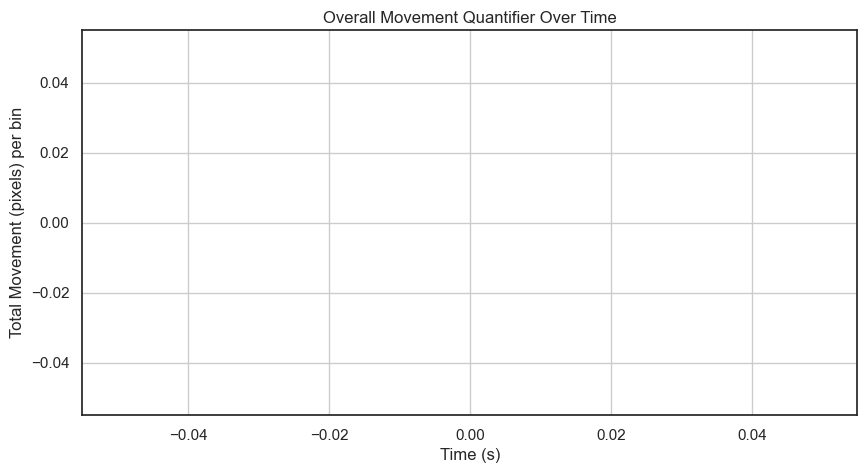

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_movement_quantifier(final_df, frame_duration=0.017, bin_duration=1.0):
    """
    Computes and plots an overall movement quantifier based on the final analysis dataframe.
    
    The function:
      - Computes the Euclidean displacement between consecutive frames where a valid center exists.
      - Uses the fact that each frame is exactly `frame_duration` seconds (default 0.017 s).
      - Groups these displacements into time bins of duration `bin_duration` seconds (default 1 s).
      - Plots the total (summed) movement per bin over time.
    
    Parameters:
       final_df     : DataFrame with columns ["frame_number", "center_x", "center_y", "notes"]
       frame_duration: Duration of one frame in seconds (default 0.017)
       bin_duration  : Duration of the time bin in seconds (default 1.0)
    """
    # Compute time for each frame (frame 1 is time 0)
    times = (final_df["frame_number"].values - 1) * frame_duration

    # Compute displacements between consecutive frames.
    # If either frame is missing (NaN), treat that interval as zero movement.
    displacements = np.zeros(len(final_df))
    for i in range(1, len(final_df)):
        x_curr = final_df.loc[i, "center_x"]
        y_curr = final_df.loc[i, "center_y"]
        x_prev = final_df.loc[i-1, "center_x"]
        y_prev = final_df.loc[i-1, "center_y"]
        if not (np.isnan(x_curr) or np.isnan(y_curr) or np.isnan(x_prev) or np.isnan(y_prev)):
            dx = x_curr - x_prev
            dy = y_curr - y_prev
            displacements[i] = np.sqrt(dx**2 + dy**2)
        else:
            displacements[i] = 0  # or you could choose np.nan if you want to ignore that interval
    
    # Determine the total time and number of bins.
    max_time = times[-1]
    n_bins = int(np.ceil(max_time / bin_duration))
    # Create bin edges (from 0 to total time)
    bin_edges = np.linspace(0, n_bins * bin_duration, n_bins + 1)
    
    # Use np.histogram with weights to sum the displacements per bin.
    movement_per_bin, _ = np.histogram(times, bins=bin_edges, weights=displacements)
    
    # Compute bin centers for plotting.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    
    # Plot the overall movement over time.
    plt.figure(figsize=(10, 5))
    plt.plot(bin_centers, movement_per_bin, marker='o', linestyle='-')
    plt.xlabel("Time (s)")
    plt.ylabel("Total Movement (pixels) per bin")
    plt.title("Overall Movement Quantifier Over Time")
    plt.grid(True)
    plt.show()
    
# Example usage:
# Assuming 'final_analysis_df' is the dataframe from interactive_smoothed_path_viewer:
plot_movement_quantifier(final_analysis_df, frame_duration=0.017, bin_duration=7.0)


# Until here, Here I start with older code

In [30]:
# try and load the behavior state_df:
for block in block_collection:
    read_behavior_state(block)
    

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_08_13\block_013\analysis\block_013_behavior_state.csv


In [127]:
block_dict.keys()

dict_keys(['023', '024', '025', '026', '027'])

In [128]:
block = block_dict['023']

In [9]:
for block in block_collection:
    block.block_get_lizard_movement()
#block.block_get_lizard_movement()

path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_012\oe_files\PV24_27_12_21_EE12_2021-12-27_11-36-41\Record Node 101\analysis\Animal=PV_24,recNames=Block0012\lizMov.mat


KeyError: "Unable to open object (object 't_static_ms' doesn't exist)"

In [131]:
# Over here is a multi-block behavior annotation cell which only gets one threshold and goes through the whole block_collection to annotate state
def rolling_window_analysis(df, window_size=1000, step_size=1000, method='clip', cap_value=99):
    """
    Perform a rolling window analysis on the movAll column of the input dataframe with outlier handling.

    Args:
        df (pd.DataFrame): Input dataframe with 't_mov_ms' (timestamps in ms) and 'movAll' (magnitudes).
        window_size (int): Size of the rolling window in milliseconds (default 10,000 ms).
        step_size (int): Step size for the rolling window in milliseconds (default 1,000 ms).
        method (str): Outlier handling method ('percentile', 'zscore', or 'clip').
        cap_value (float): Percentile or z-score threshold for outlier handling.

    Returns:
        pd.DataFrame: A dataframe containing the start time of each window and the adjusted average movAll value.
    """
    # Ensure the dataframe is sorted by time
    df = df.sort_values('t_mov_ms').reset_index(drop=True)

    # Handle outliers
    if method == 'percentile':
        lower_bound = np.percentile(df['movAll'], 100 - cap_value)
        upper_bound = np.percentile(df['movAll'], cap_value)
        df['movAll'] = np.clip(df['movAll'], lower_bound, upper_bound)
    elif method == 'zscore':
        mean = df['movAll'].mean()
        std = df['movAll'].std()
        z_threshold = cap_value
        df['movAll'] = np.clip(df['movAll'], mean - z_threshold * std, mean + z_threshold * std)
    elif method == 'clip':
        max_clip_value = cap_value  # Absolute clip value
        df['movAll'] = np.clip(df['movAll'], -max_clip_value, max_clip_value)
    else:
        raise ValueError("Invalid method. Choose from 'percentile', 'zscore', or 'clip'.")

    # Get the range of timestamps
    t_min = df['t_mov_ms'].min()
    t_max = df['t_mov_ms'].max()

    # Create the rolling window start times
    window_starts = np.arange(t_min, t_max + step_size, step_size)

    # Initialize results
    results = {'window_start': [], 'average_movAll': []}

    for start in tqdm.tqdm(window_starts):
        end = start + window_size
        window_data = df[(df['t_mov_ms'] >= start) & (df['t_mov_ms'] < end)]
        avg_movAll = window_data['movAll'].mean() if not window_data.empty else 0
        results['window_start'].append(start)
        results['average_movAll'].append(avg_movAll)

    return pd.DataFrame(results)


for block in block_collection:
    df = rolling_window_analysis(block.liz_mov_df,2000,1000)
    # Define the threshold manually
    threshold = 0.5
    
    # Classify behavior based on threshold
    df['behavior'] = df['average_movAll'].apply(lambda x: 'active' if x > threshold else 'quiet')
    
    def create_behavior_df(df):
        """
        Transform the annotated dataframe into a compact behavioral dataframe.
        
        Args:
            df (pd.DataFrame): Dataframe with 'window_start' and 'behavior' columns.
    
        Returns:
            pd.DataFrame: Compact behavioral dataframe with 'start_time', 'end_time', and 'annotation'.
        """
        behavior_df = []
        current_behavior = df['behavior'].iloc[0]
        start_time = df['window_start'].iloc[0]
    
        for i in range(1, len(df)):
            if df['behavior'].iloc[i] != current_behavior:
                end_time = df['window_start'].iloc[i]
                behavior_df.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'annotation': current_behavior
                })
                current_behavior = df['behavior'].iloc[i]
                start_time = df['window_start'].iloc[i]
        
        end_time = df['window_start'].iloc[-1] + 1000
        behavior_df.append({
            'start_time': start_time,
            'end_time': end_time,
            'annotation': current_behavior
        })
        return pd.DataFrame(behavior_df)
    
    # Create the behavioral dataframe
    behavior_df = create_behavior_df(df)
    
    # Save to block and export to CSV
    block.behavior_state = behavior_df
    csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
    behavior_df.to_csv(csv_path, index=False)
    print(f"Behavior state saved to {csv_path}")

 13%|█▎        | 205/1630 [00:00<00:00, 2035.86it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\analysis\block_023_behavior_state.csv


 13%|█▎        | 205/1639 [00:00<00:00, 2032.50it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis\block_024_behavior_state.csv


 18%|█▊        | 320/1800 [00:00<00:00, 1691.28it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_025\analysis\block_025_behavior_state.csv


 13%|█▎        | 202/1547 [00:00<00:00, 2011.61it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\analysis\block_026_behavior_state.csv


100%|██████████| 1547/1547 [00:00<00:00, 1896.12it/s]

Behavior state saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_027\analysis\block_027_behavior_state.csv


In [51]:
# over here, perform a rolling window analysis and select threshold for active/quite segmentation
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pandas as pd
def rolling_window_analysis(df, window_size=1000, step_size=1000, method='clip', cap_value=99):
    """
    Perform a rolling window analysis on the movAll column of the input dataframe with outlier handling.

    Args:
        df (pd.DataFrame): Input dataframe with 't_mov_ms' (timestamps in ms) and 'movAll' (magnitudes).
        window_size (int): Size of the rolling window in milliseconds (default 10,000 ms).
        step_size (int): Step size for the rolling window in milliseconds (default 1,000 ms).
        method (str): Outlier handling method ('percentile', 'zscore', or 'clip').
        cap_value (float): Percentile or z-score threshold for outlier handling.

    Returns:
        pd.DataFrame: A dataframe containing the start time of each window and the adjusted average movAll value.
    """
    # Ensure the dataframe is sorted by time
    df = df.sort_values('t_mov_ms').reset_index(drop=True)

    # Handle outliers
    if method == 'percentile':
        lower_bound = np.percentile(df['movAll'], 100 - cap_value)
        upper_bound = np.percentile(df['movAll'], cap_value)
        df['movAll'] = np.clip(df['movAll'], lower_bound, upper_bound)
    elif method == 'zscore':
        mean = df['movAll'].mean()
        std = df['movAll'].std()
        z_threshold = cap_value
        df['movAll'] = np.clip(df['movAll'], mean - z_threshold * std, mean + z_threshold * std)
    elif method == 'clip':
        max_clip_value = cap_value  # Absolute clip value
        df['movAll'] = np.clip(df['movAll'], -max_clip_value, max_clip_value)
    else:
        raise ValueError("Invalid method. Choose from 'percentile', 'zscore', or 'clip'.")

    # Get the range of timestamps
    t_min = df['t_mov_ms'].min()
    t_max = df['t_mov_ms'].max()

    # Create the rolling window start times
    window_starts = np.arange(t_min, t_max + step_size, step_size)

    # Initialize results
    results = {'window_start': [], 'average_movAll': []}

    for start in window_starts:
        end = start + window_size
        window_data = df[(df['t_mov_ms'] >= start) & (df['t_mov_ms'] < end)]
        avg_movAll = window_data['movAll'].mean() if not window_data.empty else 0
        results['window_start'].append(start)
        results['average_movAll'].append(avg_movAll)

    return pd.DataFrame(results)

#df =  rolling_window_analysis(block.liz_mov_df,2000,1000)
df = movement_df
# Initialize Plotly figure
fig = go.Figure()

# Add the movement trace
fig.add_trace(go.Scatter(
    x=df['window_start'],
    y=df['average_movAll'],
    mode='lines+markers',
    name='Average Movement',
    line=dict(color='blue')
))

# Add an initial threshold line
initial_threshold = 0.5
fig.add_trace(go.Scatter(
    x=df['window_start'],
    y=[initial_threshold] * len(df),
    mode='lines',
    name='Threshold',
    line=dict(color='red', dash='dash')
))

# Update layout for interactivity
fig.update_layout(
    title="Interactive Movement Threshold Selection",
    xaxis_title="Time (ms)",
    yaxis_title="Average Movement",
    sliders=[{
        "active": 5,
        "currentvalue": {"prefix": "Threshold: "},
        "steps": [
            {"label": str(round(threshold, 2)), "method": "update", 
             "args": [{"y": [df['average_movAll'], [threshold] * len(df)]}]}
            for threshold in [x / 50 for x in range(0, 50)]
        ]
    }]
)

# Show the interactive plot
fig.show()

In [112]:
for block in block_collection:
    # Define the threshold manually
    threshold = 0.6
    
    # Classify behavior based on threshold
    df['behavior'] = df['average_movAll'].apply(lambda x: 'active' if x > threshold else 'quiet')
    
    def create_behavior_df(df):
        """
        Transform the annotated dataframe into a compact behavioral dataframe.
        
        Args:
            df (pd.DataFrame): Dataframe with 'window_start' and 'behavior' columns.
    
        Returns:
            pd.DataFrame: Compact behavioral dataframe with 'start_time', 'end_time', and 'annotation'.
        """
        behavior_df = []
        current_behavior = df['behavior'].iloc[0]
        start_time = df['window_start'].iloc[0]
    
        for i in range(1, len(df)):
            if df['behavior'].iloc[i] != current_behavior:
                end_time = df['window_start'].iloc[i]
                behavior_df.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'annotation': current_behavior
                })
                current_behavior = df['behavior'].iloc[i]
                start_time = df['window_start'].iloc[i]
        
        end_time = df['window_start'].iloc[-1] + 1000
        behavior_df.append({
            'start_time': start_time,
            'end_time': end_time,
            'annotation': current_behavior
        })
        return pd.DataFrame(behavior_df)
    
    # Create the behavioral dataframe
    behavior_df = create_behavior_df(df)
    
    # Save to block and export to CSV
    block.behavior_state = behavior_df
    csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
    behavior_df.to_csv(csv_path, index=False)
    print(f"Behavior state saved to {csv_path}")

Behavior state saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_011\analysis\block_011_behavior_state.csv


In [89]:

block.left_eye_data['pupil_diameter']= block.left_eye_data['major_ax'] * block.L_pix_size
block.right_eye_data['pupil_diameter']= block.right_eye_data['major_ax'] * block.R_pix_size

In [25]:
bdf = behavior_df.rename({'annotation':'behavior_state'})

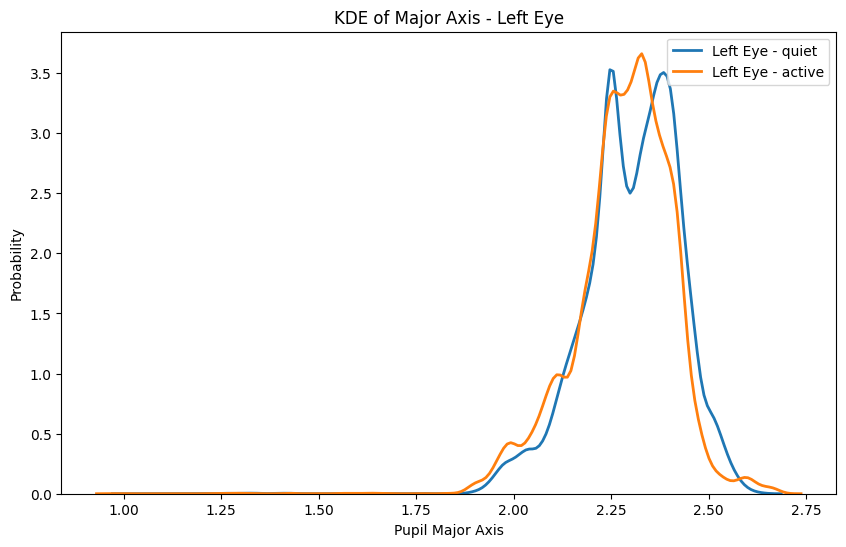

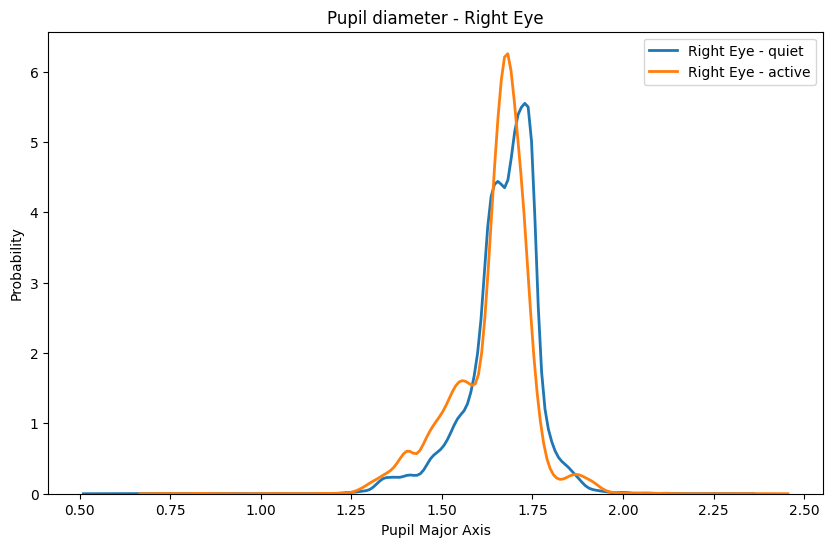

In [26]:
from matplotlib.backends.backend_pdf import PdfPages

def aggregate_and_plot_histograms(behavior_df, left_eye_data, right_eye_data, export_path=None):
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create a dictionary to store major_ax values for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period in behavior_df
    for i, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get left and right eye major_ax values for the corresponding time windows
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        # Append these values to the corresponding annotation label
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot KDE for the left eye with normalization and thicker lines
    plt.figure(figsize=(10, 6))
    for annotation in left_eye_aggregated.keys():
        sns.kdeplot(left_eye_aggregated[annotation], label=f'Left Eye - {annotation}', fill=False, common_norm=False, linewidth=2)
    plt.title('KDE of Major Axis - Left Eye')
    plt.xlabel('Pupil Major Axis')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')
    #plt.ylim(0, 1)
    
    # If export_path is provided, save to PDF
    if export_path is not None:
        pdf_pages.savefig()  # Save the current figure to the PDF
    plt.show()

    # Plot KDE for the right eye with normalization and thicker lines
    plt.figure(figsize=(10, 6))
    for annotation in right_eye_aggregated.keys():
        sns.kdeplot(right_eye_aggregated[annotation], label=f'Right Eye - {annotation}', fill=False, common_norm=False, linewidth=2)
    plt.title('Pupil diameter - Right Eye')
    plt.xlabel('Pupil Major Axis')
    plt.ylabel('Probability')
    #plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.grid(False)
    
    # If export_path is provided, save to PDF
    if export_path is not None:
        pdf_pages.savefig()  # Save the current figure to the PDF
        pdf_pages.close()  # Close the PDF after saving both figures

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_kde_based_on_lizard_movement.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_histograms(bdf, left_eye_data, right_eye_data, export_path=None)



In [20]:
block.behavior_state['len'] = block.behavior_state['end_time_ms'] - block.behavior_state['start_time_ms']

In [52]:
read_behavior_state(block)

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\block_007_behavior_state.csv


,start_time,end_time,annotation
0,5268.0,19268.0,active
1,19268.0,262268.0,quiet
2,262268.0,264268.0,active
3,264268.0,269268.0,quiet
4,269268.0,280268.0,active
...,...,...,...
75,1698268.0,1708268.0,quiet
76,1708268.0,1726268.0,active
77,1726268.0,1744268.0,quiet
78,1744268.0,1758268.0,active


In [22]:
block.behavior_state

,start_time,end_time,annotation,start_time_ms,end_time_ms,len
0,27892.0,250892.0,quiet,27892.0,250892.0,223000.0
1,250892.0,251892.0,active,250892.0,251892.0,1000.0
2,251892.0,398892.0,quiet,251892.0,398892.0,147000.0
3,398892.0,423892.0,active,398892.0,423892.0,25000.0
4,423892.0,671892.0,quiet,423892.0,671892.0,248000.0
5,671892.0,684892.0,active,671892.0,684892.0,13000.0
6,684892.0,731892.0,quiet,684892.0,731892.0,47000.0
7,731892.0,741892.0,active,731892.0,741892.0,10000.0
8,741892.0,762892.0,quiet,741892.0,762892.0,21000.0
9,762892.0,767892.0,active,762892.0,767892.0,5000.0


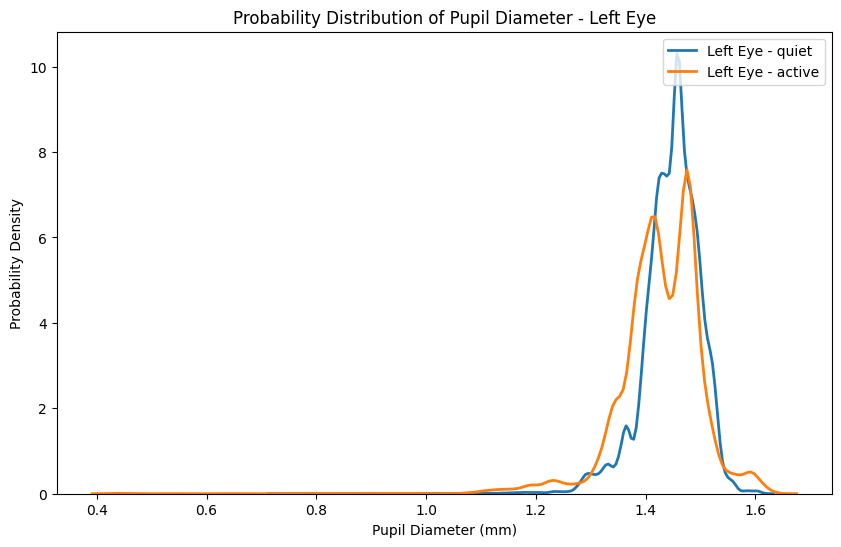

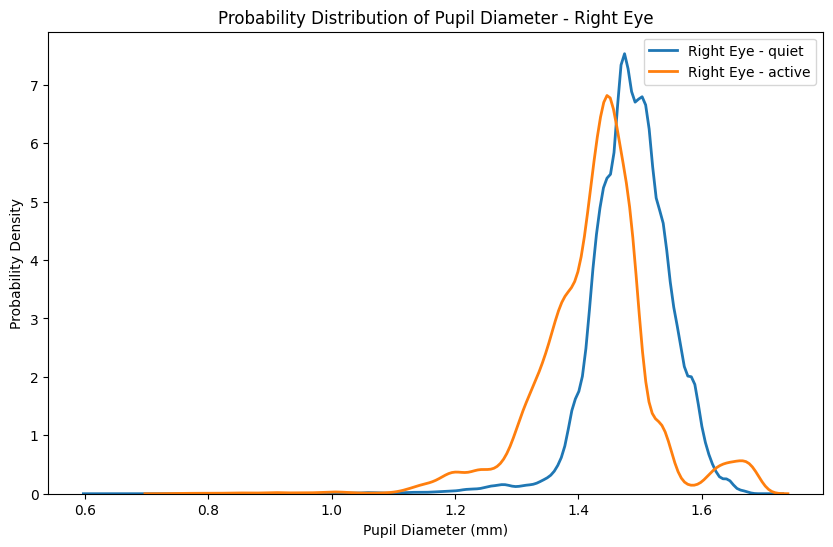

In [30]:
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def aggregate_and_plot_histograms(behavior_df, left_eye_data, right_eye_data, export_path=None):
    """
    Generate and save KDE plots for pupil diameter distributions under different behavioral annotations.

    Args:
        behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
        left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
        right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
    """
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create dictionaries to store pupil diameters for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period
    for _, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get pupil diameters for the current annotation period
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot KDE for the left eye with proper normalization
    plt.figure(figsize=(10, 6))
    for annotation, data in left_eye_aggregated.items():
        sns.kdeplot(data, label=f'Left Eye - {annotation}', bw_adjust=1, common_norm=True, fill=False, linewidth=2)
    plt.title('Probability Distribution of Pupil Diameter - Left Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Probability Density')
    plt.legend(loc='upper right')
    
    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot KDE for the right eye with proper normalization
    plt.figure(figsize=(10, 6))
    for annotation, data in right_eye_aggregated.items():
        sns.kdeplot(data, label=f'Right Eye - {annotation}', bw_adjust=1, common_norm=True, fill=False, linewidth=2)
    plt.title('Probability Distribution of Pupil Diameter - Right Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Probability Density')
    plt.legend(loc='upper right')
    
    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
        pdf_pages.close()

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_kde_based_on_lizard_movement.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_histograms(block.behavior_state, left_eye_data, right_eye_data, export_path=None)


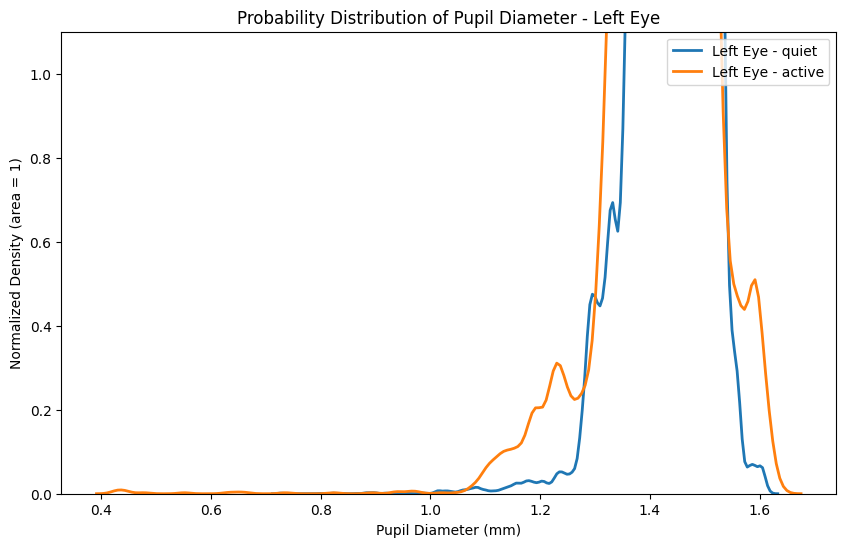

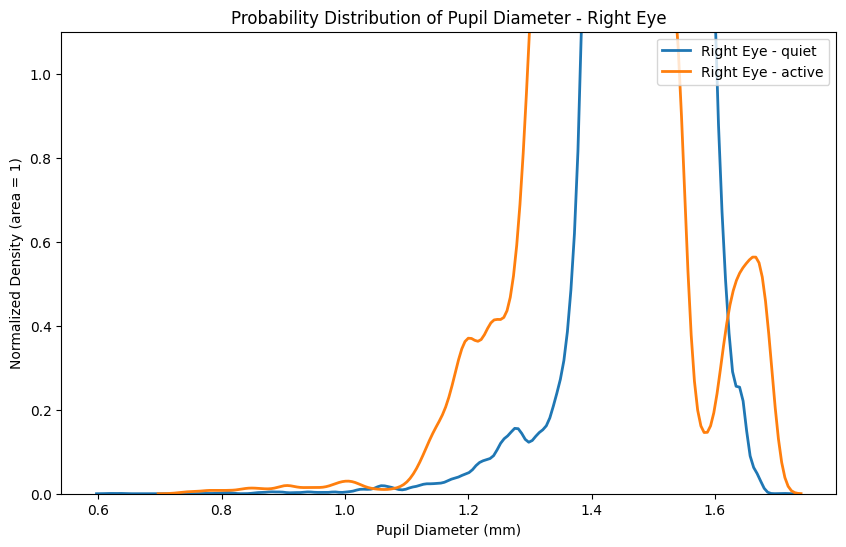

In [32]:
def aggregate_and_plot_histograms(behavior_df, left_eye_data, right_eye_data, export_path=None):
    """
    Generate and save KDE plots for pupil diameter distributions under different behavioral annotations.

    Args:
        behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
        left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
        right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
    """
    from matplotlib.backends.backend_pdf import PdfPages
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create dictionaries to store pupil diameters for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period
    for _, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get pupil diameters for the current annotation period
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot KDE for the left eye
    plt.figure(figsize=(10, 6))
    for annotation, data in left_eye_aggregated.items():
        sns.kdeplot(data, label=f'Left Eye - {annotation}', fill=False, linewidth=2, bw_adjust=1)
    plt.title('Probability Distribution of Pupil Diameter - Left Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Normalized Density (area = 1)')
    plt.legend(loc='upper right')
    plt.ylim(0, 1.1)  # Normalize the y-axis if desired

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot KDE for the right eye
    plt.figure(figsize=(10, 6))
    for annotation, data in right_eye_aggregated.items():
        sns.kdeplot(data, label=f'Right Eye - {annotation}', fill=False, linewidth=2, bw_adjust=1)
    plt.title('Probability Distribution of Pupil Diameter - Right Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Normalized Density (area = 1)')
    plt.legend(loc='upper right')
    plt.ylim(0, 1.1)  # Normalize the y-axis if desired

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
        pdf_pages.close()

    plt.show()

aggregate_and_plot_histograms(block.behavior_state, left_eye_data, right_eye_data, export_path=None)

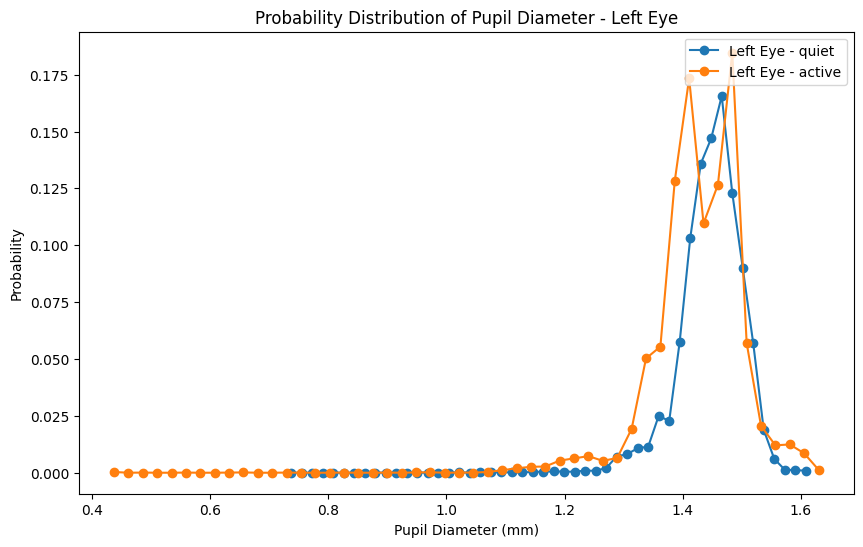

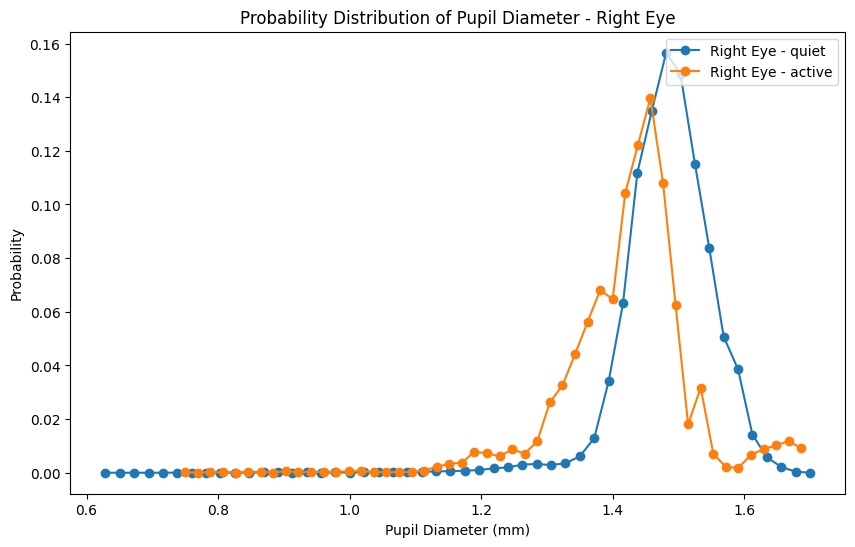

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def aggregate_and_plot_probabilities(behavior_df, left_eye_data, right_eye_data, export_path=None, num_bins=50):
    """
    Generate and save probability plots for pupil diameter distributions under different behavioral annotations.

    Args:
        behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
        left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
        right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create dictionaries to store pupil diameters for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period
    for _, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get pupil diameters for the current annotation period
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter']
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter']
        
        # Remove NaN values
        left_eye_values = left_eye_values.dropna()
        right_eye_values = right_eye_values.dropna()
        
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Plot probabilities for the left eye
    plt.figure(figsize=(10, 6))
    for annotation, data in left_eye_aggregated.items():
        data = np.array(data)
        data = data[~np.isnan(data)]  # Ensure no NaN values
        counts, bin_edges = np.histogram(data, bins=num_bins, density=True)
        probabilities = counts / np.sum(counts)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, probabilities, label=f'Left Eye - {annotation}', marker='o')
    plt.title('Probability Distribution of Pupil Diameter - Left Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(10, 6))
    for annotation, data in right_eye_aggregated.items():
        data = np.array(data)
        data = data[~np.isnan(data)]  # Ensure no NaN values
        counts, bin_edges = np.histogram(data, bins=num_bins, density=True)
        probabilities = counts / np.sum(counts)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, probabilities, label=f'Right Eye - {annotation}', marker='o')
    plt.title('Probability Distribution of Pupil Diameter - Right Eye')
    plt.xlabel('Pupil Diameter (mm)')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
        pdf_pages.close()

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_probabilities_based_on_lizard_movement.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_probabilities(block.behavior_state, left_eye_data, right_eye_data, export_path=None)


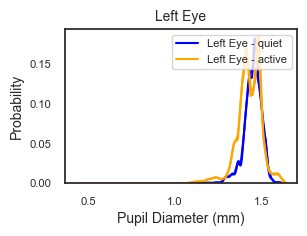

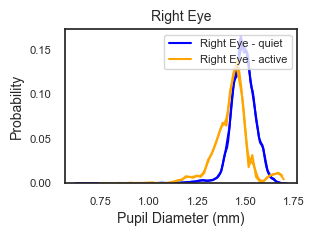

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

def aggregate_and_plot_probabilities_seaborn(block, export_path=None, num_bins=50):
    """
    Generate and save elegant Seaborn-based probability plots for pupil diameter distributions.

    Args:
        block: BlockSync object with the following internal attributes:
            behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    behavior_df = block.behavior_state
    left_eye_data = block.left_eye_data
    right_eye_data = block.right_eye_data
    # Convert behavior_df times from seconds to milliseconds
    behavior_df['start_time_ms'] = behavior_df['start_time']
    behavior_df['end_time_ms'] = behavior_df['end_time']

    # Create dictionaries to store pupil diameters for each annotation
    left_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}
    right_eye_aggregated = {label: [] for label in behavior_df['annotation'].unique()}

    # Loop through each annotation period
    for _, row in behavior_df.iterrows():
        start_time_ms = row['start_time_ms']
        end_time_ms = row['end_time_ms']
        annotation = row['annotation']
        
        # Get pupil diameters for the current annotation period
        left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
        right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter'].dropna()
        
        left_eye_aggregated[annotation].extend(left_eye_values)
        right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
     # Custom color mapping
    color_map = {'quiet': 'blue', 'active': 'orange'}
    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in left_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True, label=f'Left Eye - {annotation}', alpha=0.7,
                     color=color_map.get(annotation, 'gray'), fill=False)
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)
    
    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in right_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True, label=f'Right Eye - {annotation}', alpha=0.7,
                    color=color_map.get(annotation, 'gray'), fill=False)
        
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)

    # Save the current plot to the PDF if export_path is provided
    if export_path is not None:
        pdf_pages.savefig()
        pdf_pages.close()

    plt.show()

# Example usage:
export_path = block.analysis_path / 'pupil_behavior_probabilities_based_on_lizard_movement_seaborn.pdf'
left_eye_data = block.left_eye_data
right_eye_data = block.right_eye_data
aggregate_and_plot_probabilities_seaborn(block, export_path=None)


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def aggregate_and_plot_probabilities_multi_blocks(block_list, export_path=None, num_bins=50):
    """
    Generate and save elegant Seaborn-based probability plots for pupil diameter distributions
    across multiple blocks.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}
    
    # Loop through each block to aggregate data
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']
            
            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter'].dropna()
            
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in left_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
                     label=f'Left Eye - {annotation}', alpha=0.7,
                     color=color_map.get(annotation, 'gray'), fill=False)
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=100)
    for annotation, data in right_eye_aggregated.items():
        sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
                     label=f'Right Eye - {annotation}', alpha=0.7,
                     color=color_map.get(annotation, 'gray'), fill=False)
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()


In [12]:
import pandas as pd

def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
        
        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")
        
        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)
        
        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")
        
        return behavior_state_df
    
    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None

def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    



# Block Instantiation

In [1]:
# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict

#animal = 'PV_62' || block_numbers = [23,24,25,26,27]
#animal = 'PV_126' || block_numbers = [7,8,9,10,11,12,13,14] 
# Example usage:
#animals = ['PV_62','PV_126']
#animals = ['PV_57']
#block_lists = [[23,24,26,27],[7,8,9,10,11,12,13]]
#block_lists = [[5,6,7,8,9,11]]
animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

NameError: name 'pathlib' is not defined

In [5]:

# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest
#animal = 'PV_126'||block_numbers = [7,8,9,10,11,12,13,14]
bad_blocks = [6] # 
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_numbers = [23,24,25,26,27]

block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=True)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 025 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_025, new OE version
Found the sample rate for block 025 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 025
got it!
instantiated block number 026 at Path: Z:\Nimrod\experi

In [36]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:

    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 005 has a parsed events file, reading...
Getting eye brightness values for block 005...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 006 has a parsed events file, reading...
Getting eye brightness values for block 006...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 007 has a parsed events file, reading...
Getting eye brightness values for block 007...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [37]:
for block in block_collection:
    #block.block_get_lizard_movement()
    read_behavior_state(block)

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_005\analysis\block_005_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_006\analysis\block_006_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_007\analysis\block_007_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_008\analysis\block_008_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_11_25\block_009\analysis\block_009_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_57\2024_12_01\block_011\analysis\block_011_behavior_state.csv


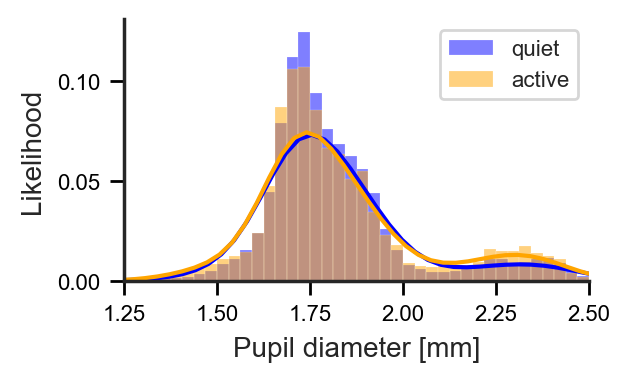

In [42]:
import os
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
def plot_combined_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Combines left and right eye
    data for each annotation into a single curve. Outputs results into a timestamped folder.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    combined_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Combine data from both eyes
            combined_aggregated[annotation].extend(left_eye_values)
            combined_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot combined data for all annotations
    fig, ax = plt.subplots(figsize=(3, 1.7), dpi=200)
    for annotation, data in combined_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True,
            ax=ax,
        )
    #ax.set_title('Combined Eye Probability Histograms', fontsize=12)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Likelihood', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_by_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "pupil_diameter_by_behavior.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "combined_aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(combined_aggregated, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv57'
plot_combined_eye_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(1.25, 2.5))

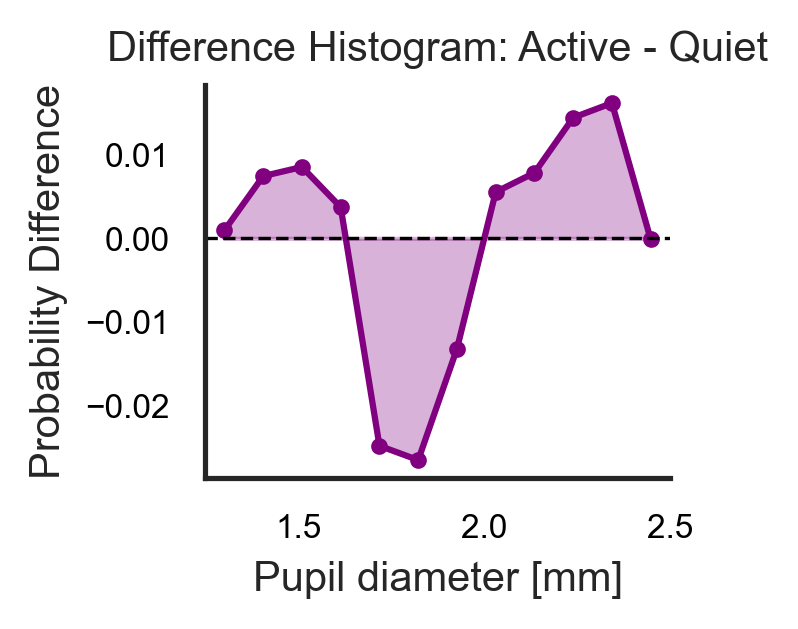

In [39]:
# subtracted graph version 1
import os
import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_difference_eye_probability_histogram(block_list, export_path=None, num_bins=40, 
                                                x_range=(1.25, 2.5), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a Seaborn-based difference histogram representing the probability difference
    between active and quiet pupil diameter distributions (active - quiet). The area between the
    difference curve and 0 is shaded for visual clarity.

    Args:
        block_list: List of BlockSync objects with these attributes:
            - behavior_state (pd.DataFrame): with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Directory to save the output (folder is created automatically if None is provided).
        num_bins (int): Number of bins to use for pupil diameter values.
        x_range (tuple): The x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) for the central 98%).
    """
    # Initialize dictionary for annotation data and a list for overall data (for bin calculation)
    combined_aggregated = {}
    all_data = []
    
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Use provided times (assumed already in ms or convert if needed)
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Prepare keys in the aggregation dictionary
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate pupil diameter data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            combined_aggregated[annotation].extend(left_vals)
            combined_aggregated[annotation].extend(right_vals)
            all_data.extend(left_vals)
            all_data.extend(right_vals)

    # Determine shared bin edges using overall data and outlier limits
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Extract and filter data for 'active' and 'quiet' annotations
    active_data = np.array(combined_aggregated.get('active', []))
    quiet_data = np.array(combined_aggregated.get('quiet', []))
    active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
    quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]

    # Compute histograms using the shared bin edges
    hist_active, _ = np.histogram(active_data, bins=bin_edges)
    hist_quiet, _ = np.histogram(quiet_data, bins=bin_edges)

    # Normalize to obtain probabilities
    total_active = np.sum(hist_active)
    total_quiet = np.sum(hist_quiet)
    prob_active = hist_active / total_active if total_active > 0 else hist_active
    prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet

    # Compute the difference: active minus quiet
    diff = prob_active - prob_quiet

    # Calculate bin midpoints for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Set up the plot using Seaborn styling
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2, 1.7), dpi=300)
    
    # Plot the difference curve with small dot markers
    ax.plot(bin_midpoints, diff, marker='o', markersize=3, linestyle='-', color='purple', label='Active - Quiet')
    # Shade the area between the curve and 0
    ax.fill_between(bin_midpoints, diff, 0, color='purple', alpha=0.3)
    # Add a dashed horizontal line at 0 for reference
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    # Set title and labels with font size 10
    ax.set_title('Difference Histogram: Active - Quiet', fontsize=10)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)
    
    # Configure tick parameters (font size 8)
    ax.tick_params(axis='both', labelsize=8)
    ax.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black')
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1, colors='black')
    
    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Set x-axis limits
    ax.set_xlim(x_range)
    #ax.legend(loc='upper right', fontsize=8)

    # Export the plot and data if an export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_difference_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        pdf_file = os.path.join(full_export_path, "pupil_diameter_difference.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        data_file = os.path.join(full_export_path, "difference_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(diff, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

plot_difference_eye_probability_histogram(block_collection, export_path=None, num_bins=12, x_range=(1.25, 2.5))

Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals\pupil_diameter_diff_comparison_2025_02_21_16_16_15


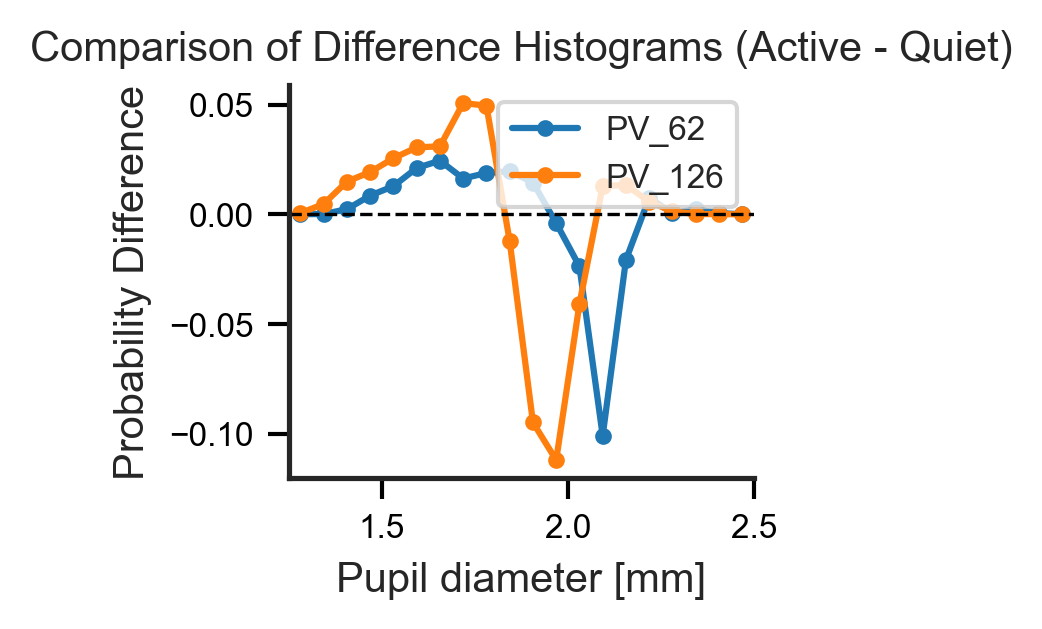

In [32]:

def compare_animals_difference_histogram(block_dict, export_path=None, num_bins=40, 
                                           x_range=(1.25, 2.5), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save a comparison graph of difference histograms (active - quiet) for multiple animals.
    The block_dict keys include an animal identifier (formatted as 'PV_x', where x is one to three digits)
    and a block identifier (e.g., 'PV_62_block_023'). Blocks are grouped by animal, and for each animal,
    pupil diameter data for 'active' and 'quiet' annotations are aggregated across blocks. A normalized
    difference histogram (active - quiet) is computed using shared bin edges and plotted on a single graph.
    
    Args:
        block_dict (dict): Dictionary where each key is a string containing the animal identifier (e.g., 'PV_62_block_023')
                           and the value is a block object. Each block must have:
                                - behavior_state (pd.DataFrame): with columns 'start_time', 'end_time', and 'annotation'.
                                - left_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
                                - right_eye_data (pd.DataFrame): with columns 'ms_axis' and 'pupil_diameter'.
        export_path (str): Directory to save the output plot and data. A timestamped folder is created if provided.
        num_bins (int): Number of bins for the pupil diameter values.
        x_range (tuple): x-axis range (min, max) for the plot.
        outlier_percentiles (tuple): Percentile range for outlier removal (e.g., (0.001, 99.999)).
    """
    overall_data = []
    animal_data = {}  # Dictionary to store aggregated data per animal
    
    # Process each block; extract animal name from the key (assumes format 'PV_x_block_YYY')
    for key, block in block_dict.items():
        # Extract animal name (e.g., "PV_62") using a regex or split method
        match = re.match(r'^(PV_\d+)', key)
        if not match:
            continue  # Skip if the key does not contain the expected animal identifier
        animal = match.group(1)
        if animal not in animal_data:
            animal_data[animal] = {'active': [], 'quiet': []}
        
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Assume times are already in milliseconds; if not, convert accordingly.
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']
        
        # Aggregate pupil diameter data for the 'active' and 'quiet' annotations
        for _, row in behavior_df.iterrows():
            annotation = row['annotation']
            if annotation not in ['active', 'quiet']:
                continue
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            left_vals = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')["pupil_diameter"].dropna()
            right_vals = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')["pupil_diameter"].dropna()
            
            animal_data[animal][annotation].extend(left_vals)
            animal_data[animal][annotation].extend(right_vals)
            
            # Also aggregate for overall bin edge determination
            overall_data.extend(left_vals)
            overall_data.extend(right_vals)
    
    # Compute outlier limits and shared bin edges
    outlier_min, outlier_max = np.percentile(overall_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Prepare a color palette (one color per animal)
    colors = sns.color_palette('tab10', n_colors=len(animal_data))
    
    animal_diffs = {}
    for idx, (animal, data_dict) in enumerate(animal_data.items()):
        # Filter data to remove outliers
        active_data = np.array(data_dict['active'])
        quiet_data = np.array(data_dict['quiet'])
        active_data = active_data[(active_data >= outlier_min) & (active_data <= outlier_max)]
        quiet_data = quiet_data[(quiet_data >= outlier_min) & (quiet_data <= outlier_max)]
        
        # Compute histograms using shared bin edges
        hist_active, _ = np.histogram(active_data, bins=bin_edges)
        hist_quiet, _ = np.histogram(quiet_data, bins=bin_edges)
        
        # Normalize to probabilities
        total_active = np.sum(hist_active)
        total_quiet = np.sum(hist_quiet)
        prob_active = hist_active / total_active if total_active > 0 else hist_active
        prob_quiet = hist_quiet / total_quiet if total_quiet > 0 else hist_quiet
        
        # Compute the difference (active - quiet)
        diff = prob_active - prob_quiet
        animal_diffs[animal] = diff
    
    # Create the comparison plot
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(2, 1.7), dpi=300)
    
    # Plot each animal's difference curve with small markers and shade the area between the curve and 0
    for idx, (animal, diff) in enumerate(animal_diffs.items()):
        ax.plot(bin_midpoints, diff, marker='o', markersize=3, linestyle='-', color=colors[idx], label=animal)
        #ax.fill_between(bin_midpoints, diff, 0, color=colors[idx], alpha=0.3)
    
    # Add a horizontal dashed reference line at 0
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    
    # Set title and axis labels with the specified font sizes
    ax.set_title('Comparison of Difference Histograms (Active - Quiet)', fontsize=10)
    ax.set_xlabel('Pupil diameter [mm]', fontsize=10)
    ax.set_ylabel('Probability Difference', fontsize=10)
    
    # Configure tick parameters
    ax.tick_params(axis='both', which='both', bottom=True, left=True)

    ax.tick_params(axis='both', labelsize=8)
    ax.tick_params(axis='both', direction='out', which='major', length=5, width=1, colors='black')
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1, colors='black')
    
    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim(x_range)
    ax.legend(loc='upper right', fontsize=8)
    
    # Optionally export the plot and data if an export path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"pupil_diameter_diff_comparison_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        
        pdf_file = os.path.join(full_export_path, "pupil_diameter_diff_comparison.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        
        data_file = os.path.join(full_export_path, "animal_diff_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(animal_diffs, f)
        
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_between animals'
compare_animals_difference_histogram(block_dict, export_path=export_path, num_bins=20, 
                                           x_range=(1.25, 2.5), outlier_percentiles=(0.001, 99.999))

In [23]:
block_dict.keys()

dict_keys(['PV_62_block_023', 'PV_62_block_024', 'PV_62_block_026', 'PV_62_block_027', 'PV_126_block_007', 'PV_126_block_008', 'PV_126_block_009', 'PV_126_block_010', 'PV_126_block_011', 'PV_126_block_012', 'PV_126_block_013'])

In [22]:
import numpy as np
import pickle
from tqdm import tqdm

def monte_carlo_randomization_combined(data_file, condition1, condition2, n_permutations=10000):
    """
    Monte Carlo randomization test for combined eye data.

    Args:
        data_file (str): Path to the exported aggregated data pickle file.
        condition1 (str): First condition (e.g., 'quiet').
        condition2 (str): Second condition (e.g., 'active').
        n_permutations (int): Number of random shuffles for the test.

    Returns:
        dict: Contains observed statistic, p-value, and null distribution.
    """
    # Load combined data
    with open(data_file, 'rb') as f:
        data = pickle.load(f)

    # Extract data for the two conditions
    data1 = np.array(data[condition1])
    data2 = np.array(data[condition2])

    # Calculate observed difference in means
    observed_stat = np.mean(data1) - np.mean(data2)

    # Combine all data and labels
    combined_data = np.concatenate((data1, data2))
    labels = np.array([1] * len(data1) + [0] * len(data2))

    # Null distribution from shuffled labels
    null_dist = []
    for _ in tqdm(range(n_permutations), desc="Shuffling iterations"):
        np.random.shuffle(labels)
        shuffled_data1 = combined_data[labels == 1]
        shuffled_data2 = combined_data[labels == 0]
        null_dist.append(np.mean(shuffled_data1) - np.mean(shuffled_data2))

    # Calculate p-value
    p_value = (np.sum(np.abs(null_dist) >= np.abs(observed_stat)) + 1) / (n_permutations + 1)

    # Return results
    return {
        "observed_stat": observed_stat,
        "p_value": p_value,
        "null_distribution": null_dist
    }


In [23]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_null_distribution(result_dict):
    """
    Visualize the null distribution and observed statistic.

    Args:
        result_dict (dict): Output from the Monte Carlo calculation function.
                            Must contain "observed_stat" and "null_distribution".
    """
    observed_stat = result_dict["observed_stat"]
    null_dist = result_dict["null_distribution"]

    # Create the figure
    fig, ax = plt.subplots(figsize=(3, 2), dpi=150)

    # Density estimation for the null distribution
    kde = gaussian_kde(null_dist)
    x_vals = np.linspace(min(null_dist), max(null_dist), 500)
    y_vals = kde(x_vals)

    # Plot shaded null distribution
    ax.fill_between(x_vals, y_vals, color='blue', alpha=0.5, label='Shuffled Distribution')

    # Mark the observed statistic
    ax.axvline(observed_stat, color='red', linestyle='--', label=f'Observed Value: {observed_stat:.3f}')

    # Customize plot aesthetics
    ax.set_title("Null Distribution vs Observed Statistic", fontsize=10)
    ax.set_xlabel("Difference in Means", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.legend(fontsize=8)

    # Display plot
    plt.tight_layout()
    plt.show()


In [24]:
data_file = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62\pupil_diameter_by_behavior_2024_12_25_00_47_11\combined_aggregated_data.pkl"
result = monte_carlo_randomization_combined(data_file, 'quiet', 'active', n_permutations=10000)
print(f"Observed Stat: {result['observed_stat']}")
print(f"P-Value: {result['p_value']}")


Shuffling iterations: 100%|██████████| 10000/10000 [03:36<00:00, 46.27it/s]

Observed Stat: 0.3252451077572438
P-Value: 9.999000099990002e-05


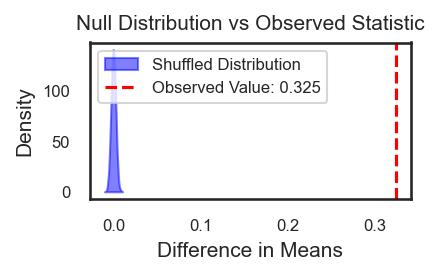

In [25]:
plot_null_distribution(result)

In [18]:
# perform a monte-carlo shuffle statistical analysis:
import numpy as np
import pickle
from scipy.stats import percentileofscore

def monte_carlo_randomization_test_pupil_separate_eyes(data_file, condition1, condition2, n_permutations=10000):
    """
    Monte Carlo randomization test for pupil diameter differences between two conditions.
    
    Args:
        data_file (str): Path to the exported aggregated data pickle file.
        condition1 (str): First condition (e.g., 'quiet').
        condition2 (str): Second condition (e.g., 'active').
        n_permutations (int): Number of random shuffles for the test.
        
    Returns:
        dict: Contains observed statistic, p-value, and null distribution.
    """
    # Load aggregated data
    with open(data_file, 'rb') as f:
        data = pickle.load(f)

    # Extract data for left and right eyes
    left_eye = data['left_eye']
    right_eye = data['right_eye']

    # Combine data for both conditions
    data1 = np.array(left_eye[condition1] + right_eye[condition1])
    data2 = np.array(left_eye[condition2] + right_eye[condition2])

    # Calculate observed difference in means
    observed_stat = np.mean(data1) - np.mean(data2)

    # Combine all data and labels
    combined_data = np.concatenate((data1, data2))
    labels = np.array([1] * len(data1) + [0] * len(data2))

    # Null distribution from shuffled labels
    null_dist = []
    for _ in range(n_permutations):
        np.random.shuffle(labels)
        shuffled_data1 = combined_data[labels == 1]
        shuffled_data2 = combined_data[labels == 0]
        null_dist.append(np.mean(shuffled_data1) - np.mean(shuffled_data2))

    # Calculate p-value
    p_value = (np.sum(np.abs(null_dist) >= np.abs(observed_stat)) + 1) / (n_permutations + 1)

    # Return results
    return {
        "observed_stat": observed_stat,
        "p_value": p_value,
        "null_distribution": null_dist
    }

# Example usage
data_file = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_pv62\pupil_diameter_by_behavior_2024_12_25_00_47_11\combined_aggregated_data.pkl"
result = monte_carlo_randomization_test(data_file, 'quiet', 'active', n_permutations=1000)
print(f"Observed Stat: {result['observed_stat']}")
print(f"P-Value: {result['p_value']}")


KeyError: 'left_eye'

Shuffling iterations: 100%|██████████| 1000/1000 [00:22<00:00, 44.29it/s]


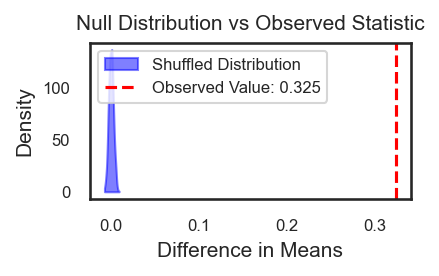

Observed Stat: 0.3252451077572438
P-Value: 0.000999000999000999


In [21]:
import numpy as np
import pickle
from tqdm import tqdm

def monte_carlo_randomization_combined(data_file, condition1, condition2, n_permutations=10000):
    """
    Monte Carlo randomization test for combined eye data.

    Args:
        data_file (str): Path to the exported aggregated data pickle file.
        condition1 (str): First condition (e.g., 'quiet').
        condition2 (str): Second condition (e.g., 'active').
        n_permutations (int): Number of random shuffles for the test.

    Returns:
        dict: Contains observed statistic, p-value, and null distribution.
    """
    # Load combined data
    with open(data_file, 'rb') as f:
        data = pickle.load(f)

    # Extract data for the two conditions
    data1 = np.array(data[condition1])
    data2 = np.array(data[condition2])

    # Calculate observed difference in means
    observed_stat = np.mean(data1) - np.mean(data2)

    # Combine all data and labels
    combined_data = np.concatenate((data1, data2))
    labels = np.array([1] * len(data1) + [0] * len(data2))

    # Null distribution from shuffled labels
    null_dist = []
    for _ in tqdm(range(n_permutations), desc="Shuffling iterations"):
        np.random.shuffle(labels)
        shuffled_data1 = combined_data[labels == 1]
        shuffled_data2 = combined_data[labels == 0]
        null_dist.append(np.mean(shuffled_data1) - np.mean(shuffled_data2))

    # Calculate p-value
    p_value = (np.sum(np.abs(null_dist) >= np.abs(observed_stat)) + 1) / (n_permutations + 1)

    # Return results
    return {
        "observed_stat": observed_stat,
        "p_value": p_value,
        "null_distribution": null_dist
    }


Exported plots and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_split_pv62\split_eye_pupil_diameter_behavior_2024_12_25_00_47_41


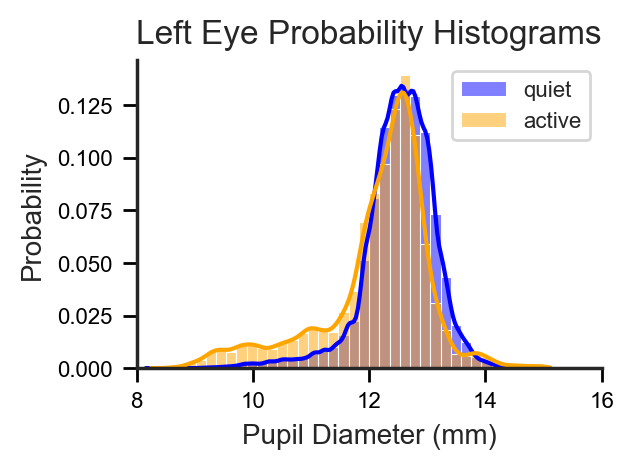

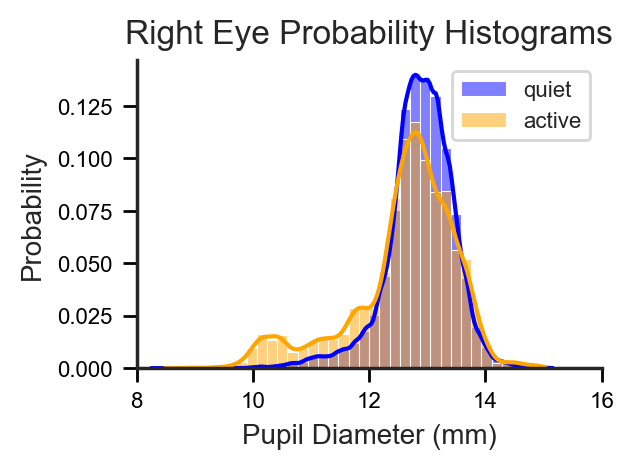

In [219]:
def plot_split_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Separates data
    into two plots: one for the left eye and one for the right eye.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Add data to respective dictionaries
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot for left eye
    fig_left, ax_left = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'), kde=True,
            ax=ax_left,
        )
    ax_left.set_title('Left Eye Probability Histograms', fontsize=12)
    ax_left.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_left.set_ylabel('Probability', fontsize=10)
    ax_left.tick_params(axis='both', labelsize=8)
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['top'].set_visible(False)
    ax_left.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax_left.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax_left.set_xlim(x_range)
    ax_left.legend(loc='upper right', fontsize=8)

    # Plot for right eye
    fig_right, ax_right = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True,
            ax=ax_right,
        )
    
    ax_right.set_title('Right Eye Probability Histograms', fontsize=12)
    ax_right.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_right.set_ylabel('Probability', fontsize=10)
    ax_right.tick_params(axis='both', labelsize=8)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)
    ax_right.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax_right.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax_right.set_xlim(x_range)
    ax_right.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"split_eye_pupil_diameter_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save left eye plot
        pdf_file_left = os.path.join(full_export_path, "left_eye_pupil_vs_behavior.pdf")
        fig_left.savefig(pdf_file_left, format='pdf', bbox_inches='tight', dpi=300)

        # Save right eye plot
        pdf_file_right = os.path.join(full_export_path, "right_eye_pupil_vs_behavior.pdf")
        fig_right.savefig(pdf_file_right, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'left_eye': left_eye_aggregated, 'right_eye': right_eye_aggregated}, f)

        print(f"Exported plots and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_split_pv62'
plot_split_eye_probability_histograms(block_collection, export_path=export_path, num_bins=40, x_range=(8, 16))

In [192]:
print(block.L_pix_size)

0.045


In [175]:
block.L_pix_size = 0.044

In [176]:
for block in block_collection:
    # calibrate pupil diameter:
    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [178]:
internal_df = pd.DataFrame(columns=['L_pix_size', 'R_pix_size'])
internal_df.at[0, 'L_pix_size'] = block.L_pix_size
internal_df.at[0, 'R_pix_size'] = block.R_pix_size
internal_df.to_csv(block.analysis_path / 'LR_pix_size.csv', index=False)

In [10]:
print(block.L_pix_size,block.R_pix_size)

0.04227545705393053 0.04446860679524895


In [191]:
block.calibrate_pixel_size(10)

got the calibration values from the analysis folder


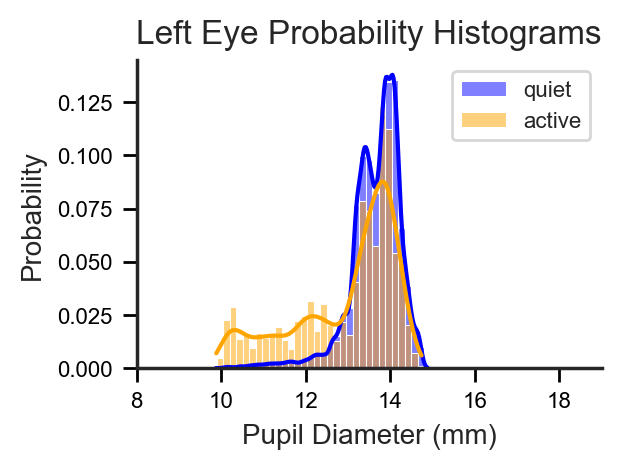

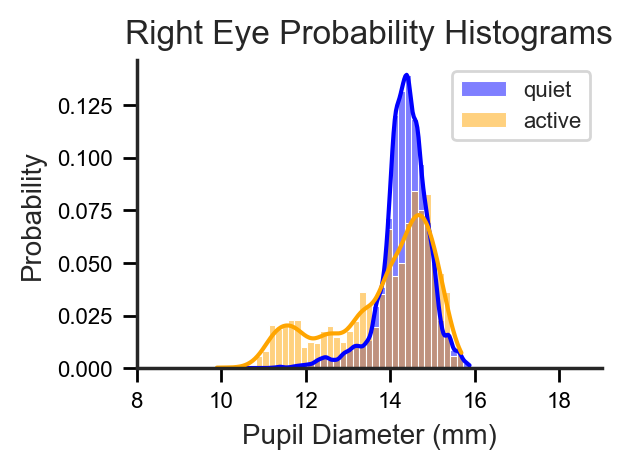

In [187]:
def plot_split_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Separates data
    into two plots: one for the left eye and one for the right eye.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the output (folder created automatically if None is provided).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Add data to respective dictionaries
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot for left eye
    fig_left, ax_left = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'), kde=True,
            ax=ax_left,
        )
    ax_left.set_title('Left Eye Probability Histograms', fontsize=12)
    ax_left.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_left.set_ylabel('Probability', fontsize=10)
    ax_left.tick_params(axis='both', labelsize=8)
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['top'].set_visible(False)
    ax_left.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax_left.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax_left.set_xlim(x_range)
    ax_left.legend(loc='upper right', fontsize=8)

    # Plot for right eye
    fig_right, ax_right = plt.subplots(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True,
            ax=ax_right,
        )
    
    ax_right.set_title('Right Eye Probability Histograms', fontsize=12)
    ax_right.set_xlabel('Pupil Diameter (mm)', fontsize=10)
    ax_right.set_ylabel('Probability', fontsize=10)
    ax_right.tick_params(axis='both', labelsize=8)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)
    ax_right.tick_params(axis='both', direction='out', which='major',length=5, width=1, colors='black', bottom=True, left=True)
    ax_right.tick_params(axis='both', direction='out', which='minor', length=5, width=1,colors='black', bottom=True, left=True)
    ax_right.set_xlim(x_range)
    ax_right.legend(loc='upper right', fontsize=8)

    # Export section
    if export_path is not None:
        # Create timestamped folder
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"split_eye_pupil_diameter_behavior_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save left eye plot
        pdf_file_left = os.path.join(full_export_path, "left_eye_pupil_vs_behavior.pdf")
        fig_left.savefig(pdf_file_left, format='pdf', bbox_inches='tight', dpi=300)

        # Save right eye plot
        pdf_file_right = os.path.join(full_export_path, "right_eye_pupil_vs_behavior.pdf")
        fig_right.savefig(pdf_file_right, format='pdf', bbox_inches='tight', dpi=300)

        # Save raw data
        data_file = os.path.join(full_export_path, "aggregated_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'left_eye': left_eye_aggregated, 'right_eye': right_eye_aggregated}, f)

        print(f"Exported plots and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\pupil_diameter_behavior_split_pv62'
plot_split_eye_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(8, 19))

In [ ]:
#older versionss

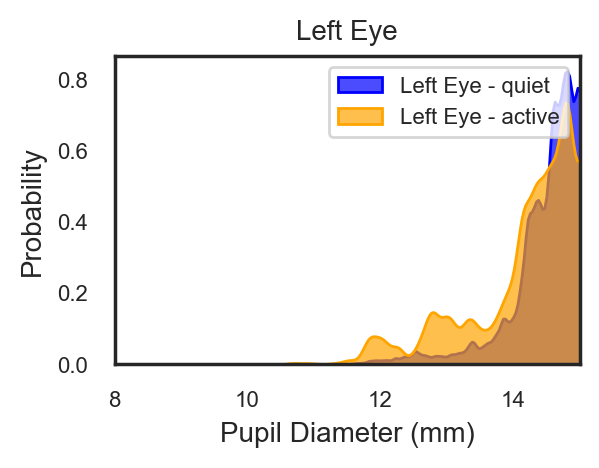

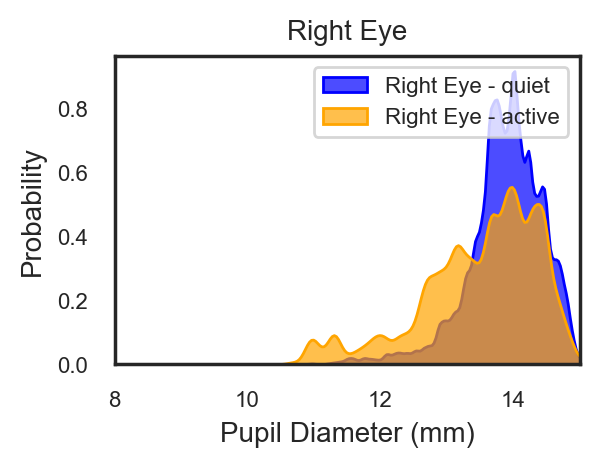

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def aggregate_and_plot_probabilities_multi_blocks(block_list, export_path=None, num_bins=50):
    """
    Generate and save elegant Seaborn-based probability plots for pupil diameter distributions
    across multiple blocks.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}
    
    # Loop through each block to aggregate data
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']
            
            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('(ms_axis >= @start_time_ms) and (ms_axis <= @end_time_ms)')['pupil_diameter'].dropna()
            
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
        #              label=f'Left Eye - {annotation}', alpha=0.7,
        #              color=color_map.get(annotation, 'gray'), fill=False)
        sns.kdeplot(
        data,
        label=f'Left Eye - {annotation}',
        alpha=0.7,
        color=color_map.get(annotation, 'gray'),
        bw_adjust=0.5,  # Adjust bandwidth if needed
        fill=True,
        common_norm=False)  # Ensures each annotation's curve integrates to 1
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(8,15)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # sns.histplot(data, bins=num_bins, stat='probability', element='poly', kde=True,
        #              label=f'Right Eye - {annotation}', alpha=0.7,
        #              color=color_map.get(annotation, 'gray'), fill=False)
        
        sns.kdeplot(
            data,
            label=f'Right Eye - {annotation}',
            alpha=0.7,
            color=color_map.get(annotation, 'gray'),
            bw_adjust=0.5,  # Adjust bandwidth if needed
            fill=True,
            common_norm=False  # Ensures each annotation's curve integrates to 1
        )
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(8,15)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()
aggregate_and_plot_probabilities_multi_blocks(block_collection, export_path=None)

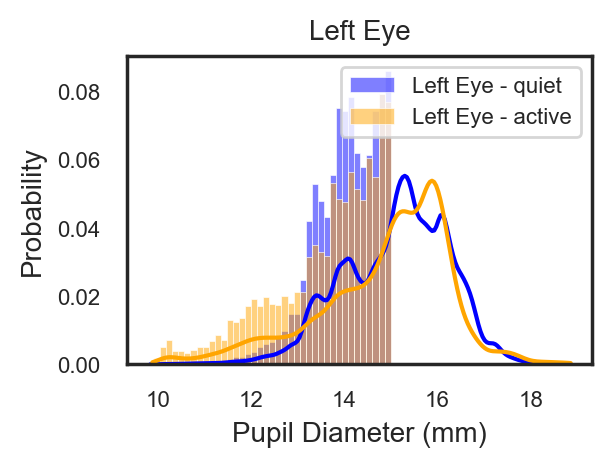

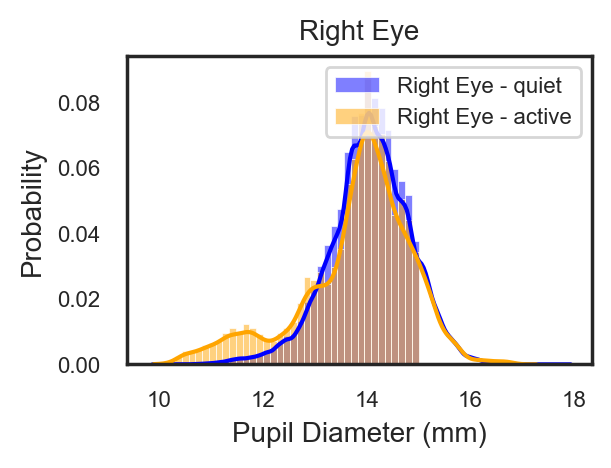

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def plot_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.001, 99.999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    left_eye_aggregated = {}
    right_eye_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in left_eye_aggregated:
                left_eye_aggregated[label] = []
            if label not in right_eye_aggregated:
                right_eye_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Add to aggregated dictionaries
            left_eye_aggregated[annotation].extend(left_eye_values)
            right_eye_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Prepare to save both figures to the same PDF
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot probabilities for the left eye
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in left_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',  # Normalize bin heights to sum to 1
            element='bars',
            label=f'Left Eye - {annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True
        )
    plt.title('Left Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlim(x_range)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()
    plt.show()

    # Plot probabilities for the right eye
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in right_eye_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',  # Normalize bin heights to sum to 1
            element='bars',
            label=f'Right Eye - {annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True
        )
    plt.title('Right Eye', fontsize=10)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlim(x_range)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()
plot_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(8, 15))

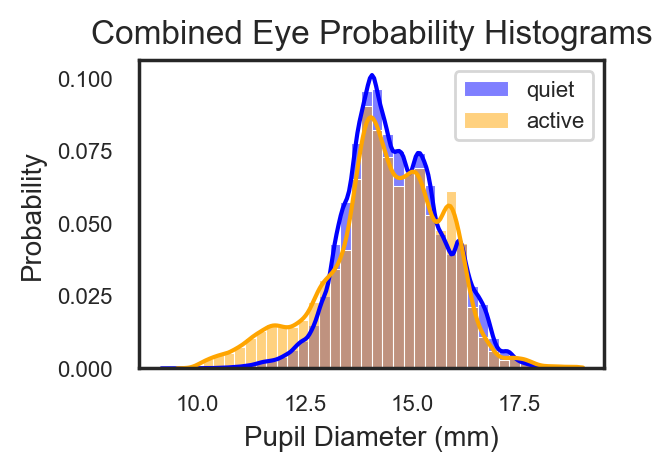

In [146]:
def plot_combined_eye_probability_histograms(block_list, export_path=None, num_bins=50, x_range=(8, 15), outlier_percentiles=(0.0001, 99.9999)):
    """
    Generate and save Seaborn-based probability histograms for pupil diameter distributions
    across multiple blocks, with outlier removal and consistent bin widths. Combines left and right eye
    data for each annotation into a single curve.

    Args:
        block_list: List of BlockSync objects with the following internal attributes:
            - behavior_df (pd.DataFrame): DataFrame with 'start_time', 'end_time', and 'annotation'.
            - left_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the left eye.
            - right_eye_data (pd.DataFrame): DataFrame with 'ms_axis' and 'pupil_diameter' for the right eye.
        export_path (str): Path to save the PDF containing the plots (optional).
        num_bins (int): Number of bins to divide the pupil diameter values.
        x_range (tuple): Tuple specifying the x-axis range (min, max).
        outlier_percentiles (tuple): Percentile range to retain (e.g., (1, 99) keeps the central 98%).
    """
    # Initialize combined dictionaries for all blocks
    combined_aggregated = {}

    # Aggregate data and remove outliers
    all_data = []  # To calculate shared bin edges
    for block in block_list:
        behavior_df = block.behavior_state
        left_eye_data = block.left_eye_data
        right_eye_data = block.right_eye_data

        # Convert behavior_df times from seconds to milliseconds
        behavior_df['start_time_ms'] = behavior_df['start_time']
        behavior_df['end_time_ms'] = behavior_df['end_time']

        # Initialize aggregation for new annotations
        for label in behavior_df['annotation'].unique():
            if label not in combined_aggregated:
                combined_aggregated[label] = []

        # Aggregate data per annotation period
        for _, row in behavior_df.iterrows():
            start_time_ms = row['start_time_ms']
            end_time_ms = row['end_time_ms']
            annotation = row['annotation']

            # Get pupil diameters for the current annotation period
            left_eye_values = left_eye_data.query('ms_axis > @start_time_ms and ms_axis < @end_time_ms')['pupil_diameter'].dropna()
            right_eye_values = right_eye_data.query('ms_axis >= @start_time_ms and ms_axis <= @end_time_ms')['pupil_diameter'].dropna()

            # Combine data from both eyes
            combined_aggregated[annotation].extend(left_eye_values)
            combined_aggregated[annotation].extend(right_eye_values)

            # Collect all data for bin edge calculation
            all_data.extend(left_eye_values)
            all_data.extend(right_eye_values)

    # Determine shared bin edges
    outlier_min, outlier_max = np.percentile(all_data, outlier_percentiles)
    bin_edges = np.linspace(max(outlier_min, x_range[0]), min(outlier_max, x_range[1]), num_bins + 1)

    # Prepare to save figure to a PDF if needed
    if export_path is not None:
        pdf_pages = PdfPages(export_path)

    # Seaborn styling
    sns.set(style="white")
    color_map = {'quiet': 'blue', 'active': 'orange'}

    # Plot combined data for all annotations
    plt.figure(figsize=(3, 2), dpi=200)
    for annotation, data in combined_aggregated.items():
        # Remove outliers
        filtered_data = [val for val in data if outlier_min <= val <= outlier_max]
        sns.histplot(
            filtered_data,
            bins=bin_edges,
            stat='probability',
            element='bars',
            label=f'{annotation}',
            alpha=0.5,
            color=color_map.get(annotation, 'gray'),kde=True
        )

    plt.title('Combined Eye Probability Histograms', fontsize=12)
    plt.xlabel('Pupil Diameter (mm)', fontsize=10)
    plt.ylabel('Probability', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.xlim(x_range)
    plt.legend(loc='upper right', fontsize=8)
    if export_path is not None:
        pdf_pages.savefig()

    if export_path is not None:
        pdf_pages.close()

    plt.show()

plot_combined_eye_probability_histograms(block_collection, export_path=None, num_bins=40, x_range=(0, 50))

In [223]:
cumulative_length = 0
for block in block_collection:
    cumulative_length+= len(block.left_eye_data) // 60 

In [226]:
cumulative_length // 60 // 60

2